In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# 1. Initial Data Loading & Inspection

In [82]:
import requests
import gzip
import shutil
import os

url = "https://adresse.data.gouv.fr/data/ban/adresses/latest/csv/adresses-75.csv.gz"
destination_path = "data/paris_adress_info.csv"
gz_path = "data/adresses-75.csv.gz"

if not os.path.exists(destination_path):
    if not os.path.exists(gz_path):
        response = requests.get(url, stream=True)
        response.raise_for_status()
        with open(gz_path, 'wb') as f:
            shutil.copyfileobj(response.raw, f)
    # Extract the csv file
    with gzip.open(gz_path, 'rb') as f_in, open(destination_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [83]:
uber_data = pd.read_csv("data/uber.csv")

uber_data.columns
uber_data.info()
display(uber_data.head())
display(uber_data.tail())
uber_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           10000 non-null  object 
 1   raw_start_location  10000 non-null  object 
 2   raw_end_location    10000 non-null  object 
 3   fee                 10000 non-null  float64
dtypes: float64(1), object(3)
memory usage: 312.6+ KB


,timestamp,raw_start_location,raw_end_location,fee
0,2023-01-18 22:21:35,"145, Rue Belliard, Paris 18e Arrondissement","315, Rue de Charenton, Paris 12e Arrondissement",16.57
1,2023-01-19 20:31:27,"127, Rue de Charenton, Paris 12e Arrondissement","1, Square de la Dordogne, Paris 17e Arrondisse...",18.61
2,2023-01-25 19:40:10,"8, Rue Richard Lenoir, Paris 11e Arrondissement","9, Rue de Cherbourg, Paris 15e Arrondissement",13.15
3,2023-01-14 10:07:15,"6, Rue Guisarde, Paris 6e Arrondissement","28, Rue Guynemer, Paris 6e Arrondissement",5.00
4,2023-01-01 21:23:11,"2, Rue Cognacq-Jay, Paris 7e Arrondissement","115, Boulevard du Montparnasse, Paris 6e Arron...",5.00


,timestamp,raw_start_location,raw_end_location,fee
9995,2023-01-14 20:46:20,"31, Rue du Transvaal, Paris 20e Arrondissement","122, Avenue Emile Zola, Paris 15e Arrondissement",8.48
9996,2023-01-08 10:39:42,"2, Passage Vérité, Paris 1er Arrondissement","94, Rue Raynouard, Paris 16e Arrondissement",8.28
9997,2023-01-03 15:44:24,"30, Rue des Grands Moulins, Paris 13e Arrondis...","40, Avenue de Villiers, Paris 17e Arrondissement",5.00
9998,2023-01-09 19:44:26,"43, Avenue Hoche, Paris 8e Arrondissement","44, Rue Bargue, Paris 15e Arrondissement",5.00
9999,2023-01-11 19:46:49,"182, Avenue de Versailles, Paris 16e Arrondiss...","6, Rue George Balanchine, Paris 13e Arrondisse...",36.15


,fee
count,10000.000000
mean,10.411971
std,8.693616
min,5.000000
25%,5.000000
50%,6.640000
75%,12.640000
max,100.760000


In [84]:
def replace_curly_apostrophes(text):
    """Replaces curly apostrophes with straight apostrophes.
    Args:
        text (str): The input text.
    Returns:
        str: The text with curly apostrophes replaced.
    """
    return text.replace("’", "'")

uber_data['raw_start_location'] = uber_data['raw_start_location'].apply(replace_curly_apostrophes)
uber_data['raw_end_location'] = uber_data['raw_end_location'].apply(replace_curly_apostrophes)

In [85]:
uber_data['fee'].describe()
uber_data.info()
display(uber_data.head())
display(uber_data.tail())
uber_data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   timestamp           10000 non-null  object 
 1   raw_start_location  10000 non-null  object 
 2   raw_end_location    10000 non-null  object 
 3   fee                 10000 non-null  float64
dtypes: float64(1), object(3)
memory usage: 312.6+ KB


,timestamp,raw_start_location,raw_end_location,fee
0,2023-01-18 22:21:35,"145, Rue Belliard, Paris 18e Arrondissement","315, Rue de Charenton, Paris 12e Arrondissement",16.57
1,2023-01-19 20:31:27,"127, Rue de Charenton, Paris 12e Arrondissement","1, Square de la Dordogne, Paris 17e Arrondisse...",18.61
2,2023-01-25 19:40:10,"8, Rue Richard Lenoir, Paris 11e Arrondissement","9, Rue de Cherbourg, Paris 15e Arrondissement",13.15
3,2023-01-14 10:07:15,"6, Rue Guisarde, Paris 6e Arrondissement","28, Rue Guynemer, Paris 6e Arrondissement",5.00
4,2023-01-01 21:23:11,"2, Rue Cognacq-Jay, Paris 7e Arrondissement","115, Boulevard du Montparnasse, Paris 6e Arron...",5.00


,timestamp,raw_start_location,raw_end_location,fee
9995,2023-01-14 20:46:20,"31, Rue du Transvaal, Paris 20e Arrondissement","122, Avenue Emile Zola, Paris 15e Arrondissement",8.48
9996,2023-01-08 10:39:42,"2, Passage Vérité, Paris 1er Arrondissement","94, Rue Raynouard, Paris 16e Arrondissement",8.28
9997,2023-01-03 15:44:24,"30, Rue des Grands Moulins, Paris 13e Arrondis...","40, Avenue de Villiers, Paris 17e Arrondissement",5.00
9998,2023-01-09 19:44:26,"43, Avenue Hoche, Paris 8e Arrondissement","44, Rue Bargue, Paris 15e Arrondissement",5.00
9999,2023-01-11 19:46:49,"182, Avenue de Versailles, Paris 16e Arrondiss...","6, Rue George Balanchine, Paris 13e Arrondisse...",36.15


,fee
count,10000.000000
mean,10.411971
std,8.693616
min,5.000000
25%,5.000000
50%,6.640000
75%,12.640000
max,100.760000


<Axes: >

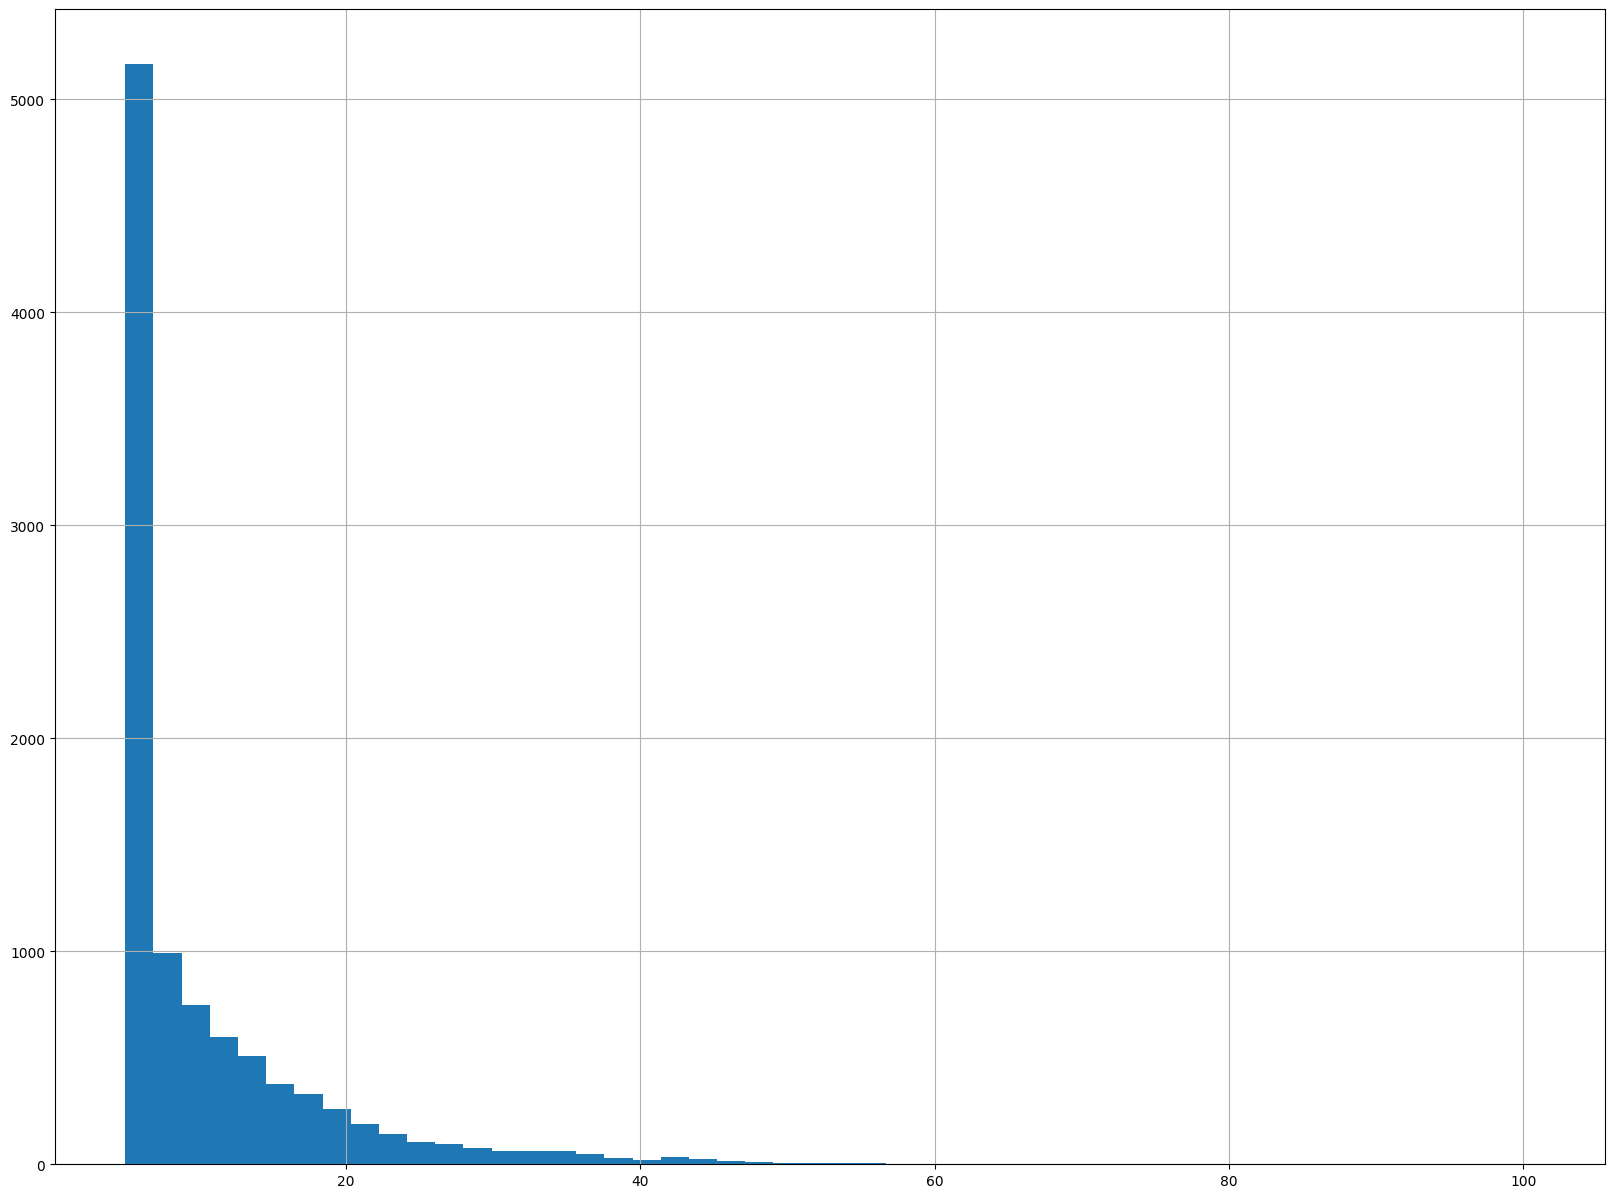

In [86]:
uber_data['fee'].hist(bins=50, figsize=(20,15))

In [87]:
meteo = pd.read_csv("data/meteo_france.csv")
meteo.columns
meteo.info()
display(meteo.head())
display(meteo.tail())
meteo.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   timestamp    744 non-null    object
 1   rain_level   744 non-null    int64 
 2   temperature  744 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 17.6+ KB


,timestamp,rain_level,temperature
0,2023-01-01 00:00:00,0,4
1,2023-01-01 01:00:00,0,4
2,2023-01-01 02:00:00,0,4
3,2023-01-01 03:00:00,0,4
4,2023-01-01 04:00:00,0,4


,timestamp,rain_level,temperature
739,2023-01-31 19:00:00,0,9
740,2023-01-31 20:00:00,0,9
741,2023-01-31 21:00:00,0,9
742,2023-01-31 22:00:00,0,9
743,2023-01-31 23:00:00,0,9


,rain_level,temperature
count,744.000000,744.000000
mean,0.357527,6.692204
std,0.745464,3.468085
min,0.000000,-3.000000
25%,0.000000,5.000000
50%,0.000000,7.000000
75%,0.000000,9.000000
max,3.000000,14.000000


In [88]:
paris_adress_info = pd.read_csv("data/paris_adress_info.csv", delimiter=';')
paris_adress_info.columns
paris_adress_info.info()
display(paris_adress_info.head())
display(paris_adress_info.tail())
paris_adress_info.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158048 entries, 0 to 158047
Data columns (total 23 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           158048 non-null  object 
 1   id_fantoir                   154684 non-null  object 
 2   numero                       158048 non-null  int64  
 3   rep                          18225 non-null   object 
 4   nom_voie                     158048 non-null  object 
 5   code_postal                  158048 non-null  int64  
 6   code_insee                   158048 non-null  int64  
 7   nom_commune                  158048 non-null  object 
 8   code_insee_ancienne_commune  0 non-null       float64
 9   nom_ancienne_commune         0 non-null       float64
 10  x                            158048 non-null  float64
 11  y                            158048 non-null  float64
 12  lon                          158048 non-null  float64
 13 

,id,id_fantoir,numero,rep,nom_voie,code_postal,code_insee,nom_commune,code_insee_ancienne_commune,nom_ancienne_commune,...,lat,type_position,alias,nom_ld,libelle_acheminement,nom_afnor,source_position,source_nom_voie,certification_commune,cad_parcelles
0,75101_cfq3tf_00001,NaN,1,NaN,Avenue du Général Lemonnier,75001,75101,Paris 1er Arrondissement,NaN,NaN,...,48.861299,parcelle,NaN,NaN,PARIS,AVENUE DU GENERAL LEMONNIER,commune,commune,1,NaN
1,75101_cfq3tf_00002,NaN,2,NaN,Avenue du Général Lemonnier,75001,75101,Paris 1er Arrondissement,NaN,NaN,...,48.861059,parcelle,NaN,NaN,PARIS,AVENUE DU GENERAL LEMONNIER,commune,commune,1,NaN
2,75101_cfq3tf_00003,NaN,3,NaN,Avenue du Général Lemonnier,75001,75101,Paris 1er Arrondissement,NaN,NaN,...,48.861516,parcelle,NaN,NaN,PARIS,AVENUE DU GENERAL LEMONNIER,commune,commune,1,NaN
3,75101_cfq3tf_00004,NaN,4,NaN,Avenue du Général Lemonnier,75001,75101,Paris 1er Arrondissement,NaN,NaN,...,48.861247,parcelle,NaN,NaN,PARIS,AVENUE DU GENERAL LEMONNIER,commune,commune,1,NaN
4,75101_cfq3tf_00005,NaN,5,NaN,Avenue du Général Lemonnier,75001,75101,Paris 1er Arrondissement,NaN,NaN,...,48.861733,parcelle,NaN,NaN,PARIS,AVENUE DU GENERAL LEMONNIER,commune,commune,1,NaN


,id,id_fantoir,numero,rep,nom_voie,code_postal,code_insee,nom_commune,code_insee_ancienne_commune,nom_ancienne_commune,...,lat,type_position,alias,nom_ld,libelle_acheminement,nom_afnor,source_position,source_nom_voie,certification_commune,cad_parcelles
158043,75108_4506_00015,75108_4506,15,NaN,Place du Havre,75008,75108,Paris 8e Arrondissement,NaN,NaN,...,48.875317,parcelle,NaN,NaN,PARIS,PLACE DU HAVRE,commune,commune,1,NaN
158044,75108_4506_00017,75108_4506,17,NaN,Place du Havre,75008,75108,Paris 8e Arrondissement,NaN,NaN,...,48.875369,parcelle,NaN,NaN,PARIS,PLACE DU HAVRE,commune,commune,1,NaN
158045,75108_0218_00002_v,75108_0218,2,v,Pont de l'Alma,75008,75108,Paris 8e Arrondissement,NaN,NaN,...,48.864042,parcelle,NaN,NaN,PARIS,PONT DE L ALMA,commune,commune,1,NaN
158046,75108_6179_00001_v,75108_6179,1,v,Place Maurice Couve de Murville,75008,75108,Paris 8e Arrondissement,NaN,NaN,...,48.874855,parcelle,NaN,NaN,PARIS,PLACE MAURICE COUVE DE MURVILLE,commune,commune,1,NaN
158047,75108_4729_00003,75108_4729,3,NaN,Pont des Invalides,75008,75108,Paris 8e Arrondissement,NaN,NaN,...,48.864259,parcelle,NaN,NaN,PARIS,PONT DES INVALIDES,commune,commune,1,NaN


,numero,code_postal,code_insee,code_insee_ancienne_commune,nom_ancienne_commune,x,y,lon,lat,alias,nom_ld,certification_commune,cad_parcelles
count,158048.000000,158048.000000,158048.000000,0.0,0.0,158048.000000,1.580480e+05,158048.000000,158048.000000,0.0,0.0,158048.0,0.0
mean,39.247140,75013.417512,75113.097356,NaN,NaN,651773.430232,6.862393e+06,2.342680,48.859763,NaN,NaN,1.0,NaN
std,49.889947,7.739461,5.111492,NaN,NaN,2878.838026,2.314942e+03,0.039224,0.020829,NaN,NaN,0.0,NaN
min,0.000000,75001.000000,75101.000000,NaN,NaN,643185.930000,6.857492e+06,2.225726,48.815692,NaN,NaN,1.0,NaN
25%,8.000000,75010.000000,75110.000000,NaN,NaN,649653.950000,6.860504e+06,2.313789,48.842699,NaN,NaN,1.0,NaN
50%,20.000000,75014.000000,75114.000000,NaN,NaN,651917.060000,6.862356e+06,2.344656,48.859436,NaN,NaN,1.0,NaN
75%,51.000000,75017.000000,75117.000000,NaN,NaN,654068.695000,6.864268e+06,2.373939,48.876686,NaN,NaN,1.0,NaN
max,422.000000,75116.000000,75120.000000,NaN,NaN,661059.890000,6.867076e+06,2.469490,48.902106,NaN,NaN,1.0,NaN


In [89]:
total_rows = len(paris_adress_info)
missing_counts = paris_adress_info.isnull().sum()
missing_percentages = (missing_counts / total_rows) * 100

# Create a DataFrame to display the counts and percentages
missing_info = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percentage (%)': missing_percentages
})
print(missing_info)

                             Missing Count  Missing Percentage (%)
id                                       0                0.000000
id_fantoir                            3364                2.128467
numero                                   0                0.000000
rep                                 139823               88.468693
nom_voie                                 0                0.000000
code_postal                              0                0.000000
code_insee                               0                0.000000
nom_commune                              0                0.000000
code_insee_ancienne_commune         158048              100.000000
nom_ancienne_commune                158048              100.000000
x                                        0                0.000000
y                                        0                0.000000
lon                                      0                0.000000
lat                                      0                0.00

## Observations on Our Datasets

### I. Data Limitations & Opportunities for Feature Engineering

Our initial dataset provides valuable information, but also highlights critical gaps that could significantly impact the accuracy and depth of our pricing model.

* **Absence of Trip Duration:** The lack of an end-of-ride timestamp prevents us from directly calculating trip duration. This is a crucial proxy for driver effort and time spent, which strongly influences pricing in ride-sharing services.
* **Geodesic vs. Actual Distance:** While we can calculate the straight-line (geodesic) distance between pickup and drop-off points, this does not represent the actual travel distance or time. Real-world factors like traffic, one-way streets, and road networks lead to discrepancies.
    * **Opportunity:** Incorporating real road network distances (e.g., via a routing API like Google Maps, OpenStreetMap, or Valhalla) would provide a far more accurate and impactful feature for pricing.
* **Missing Supply-Demand Dynamics:** A significant limitation is the absence of information on real-time demand (number of active ride requests per area/time) and supply (number of available drivers). The ratio of demand to supply is a fundamental determinant of dynamic pricing in VTC platforms.
    * **Opportunity:** Should such data become available, integrating it would likely be the most impactful enhancement to the pricing model. In its absence, features like `hour` and `arrondissement` will serve as indirect proxies for demand fluctuations.
* **No Driver Proximity Data:** We lack information on the vehicle's distance from the pickup location at the time of booking. This "empty leg" travel distance often affects driver acceptance and can sometimes influence pricing or driver behavior.

### II. Characteristics of the `fee` (Target Variable) Distribution

The distribution of the `fee` variable exhibits characteristics typical of many real-world economic metrics, with significant implications for model selection and evaluation.

* **Extreme Right Skewness:** The `fee` distribution is highly positively skewed, with a long tail extending towards higher values. For instance, the vast majority of rides are concentrated between 0 and 15 units.
* **Prevalence of Low-Cost Rides:** The highest frequency occurs for the lowest fee ranges. This indicates that most Uber trips in this dataset are relatively short or low-cost excursions.
* **Presence of High-Value Outliers:** While common, a small proportion of rides incur significantly higher fees (e.g., reaching up to ~100 units or more), representing longer or more expensive trips.
* **Implications for Modeling:**
    * **Transformation for Linear Models:** For models sensitive to skewed data (e.g., Linear Regression, Support Vector Regressors, or simple Neural Networks), a **logarithmic transformation (e.g., `np.log1p(fee)`)** is strongly recommended. This would normalize the distribution, improve linearity, stabilize variance, and lead to more robust model performance and valid statistical inferences.
    * **Robust Evaluation Metrics:** Given the skewed nature, traditional error metrics like **Root Mean Squared Error (RMSE)** can be disproportionately influenced by large errors on the few high-fee rides. **Mean Absolute Error (MAE)** provides a more interpretable average error, or evaluating RMSE/MAE on the *log-transformed* target might be more appropriate to reflect proportional errors.
    * **Outlier Management:** Outlier handling should be beneficial to prevent them from overly influencing model training.

# 2. Basic Data Cleaning & Feature Engineering (Uber Data)

In [90]:
initial_rows = uber_data.shape[0]
uber_data.dropna(inplace=True) # Use inplace for efficiency
print(f"Removed {initial_rows - uber_data.shape[0]} rows due to NaN values in initial columns.")

uber_data["datetime"] = pd.to_datetime(uber_data["timestamp"])
uber_data['day'] = pd.to_datetime(uber_data['datetime']).dt.day
uber_data['hour'] = uber_data['datetime'].dt.round('h').dt.hour

weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
uber_data['weekday'] = pd.Categorical(uber_data['datetime'].dt.day_name(), categories=weekday_order, ordered=True)
uber_data['weekday_num'] = uber_data['weekday'].cat.codes # This will give 0 for Monday, 6 for Sunday

uber_data.info()
display(uber_data.head())


Removed 0 rows due to NaN values in initial columns.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp           10000 non-null  object        
 1   raw_start_location  10000 non-null  object        
 2   raw_end_location    10000 non-null  object        
 3   fee                 10000 non-null  float64       
 4   datetime            10000 non-null  datetime64[ns]
 5   day                 10000 non-null  int32         
 6   hour                10000 non-null  int32         
 7   weekday             10000 non-null  category      
 8   weekday_num         10000 non-null  int8          
dtypes: category(1), datetime64[ns](1), float64(1), int32(2), int8(1), object(3)
memory usage: 488.8+ KB


,timestamp,raw_start_location,raw_end_location,fee,datetime,day,hour,weekday,weekday_num
0,2023-01-18 22:21:35,"145, Rue Belliard, Paris 18e Arrondissement","315, Rue de Charenton, Paris 12e Arrondissement",16.57,2023-01-18 22:21:35,18,22,Wednesday,2
1,2023-01-19 20:31:27,"127, Rue de Charenton, Paris 12e Arrondissement","1, Square de la Dordogne, Paris 17e Arrondisse...",18.61,2023-01-19 20:31:27,19,21,Thursday,3
2,2023-01-25 19:40:10,"8, Rue Richard Lenoir, Paris 11e Arrondissement","9, Rue de Cherbourg, Paris 15e Arrondissement",13.15,2023-01-25 19:40:10,25,20,Wednesday,2
3,2023-01-14 10:07:15,"6, Rue Guisarde, Paris 6e Arrondissement","28, Rue Guynemer, Paris 6e Arrondissement",5.00,2023-01-14 10:07:15,14,10,Saturday,5
4,2023-01-01 21:23:11,"2, Rue Cognacq-Jay, Paris 7e Arrondissement","115, Boulevard du Montparnasse, Paris 6e Arron...",5.00,2023-01-01 21:23:11,1,21,Sunday,6


# 3. Outlier Removal & Fee Distribution

In [91]:
total_rows = len(paris_adress_info)
missing_counts = paris_adress_info.isnull().sum()
missing_percentages = (missing_counts / total_rows) * 100

# Create a DataFrame to display the counts and percentages
missing_info = pd.DataFrame({
    'Missing Count': missing_counts,
    'Missing Percentage (%)': missing_percentages
})
print(missing_info)

print(f"Number of rows with NaNs after initial processing: {uber_data.isnull().any(axis=1).sum()}")

                             Missing Count  Missing Percentage (%)
id                                       0                0.000000
id_fantoir                            3364                2.128467
numero                                   0                0.000000
rep                                 139823               88.468693
nom_voie                                 0                0.000000
code_postal                              0                0.000000
code_insee                               0                0.000000
nom_commune                              0                0.000000
code_insee_ancienne_commune         158048              100.000000
nom_ancienne_commune                158048              100.000000
x                                        0                0.000000
y                                        0                0.000000
lon                                      0                0.000000
lat                                      0                0.00

In [92]:
original_uber_data = uber_data.copy()
initial_fee_rows = uber_data.shape[0]
q = uber_data["fee"].quantile(0.99)
uber_data = uber_data[uber_data["fee"] < q]
print(f"Removed {initial_fee_rows - uber_data.shape[0]} rows (top 1%) due to high fee outliers \
      (fee > {q:.2f}).")
print(uber_data.describe())
uber_data.info()

Removed 100 rows (top 1%) due to high fee outliers       (fee > 43.55).
               fee                       datetime          day         hour  \
count  9900.000000                           9900  9900.000000  9900.000000   
mean      9.949539  2023-01-16 17:46:44.494848512    16.178687    13.027576   
min       5.000000            2023-01-01 00:01:16     1.000000     0.000000   
25%       5.000000     2023-01-08 21:51:00.500000     8.000000     9.000000   
50%       6.580000            2023-01-16 19:12:19    16.000000    13.000000   
75%      12.410000            2023-01-24 13:54:35    24.000000    18.000000   
max      43.550000            2023-01-31 23:55:50    31.000000    23.000000   
std       7.248961                            NaN     8.971084     6.382490   

       weekday_num  
count  9900.000000  
mean      2.937677  
min       0.000000  
25%       1.000000  
50%       3.000000  
75%       5.000000  
max       6.000000  
std       2.082803  
<class 'pandas.core.frame.D

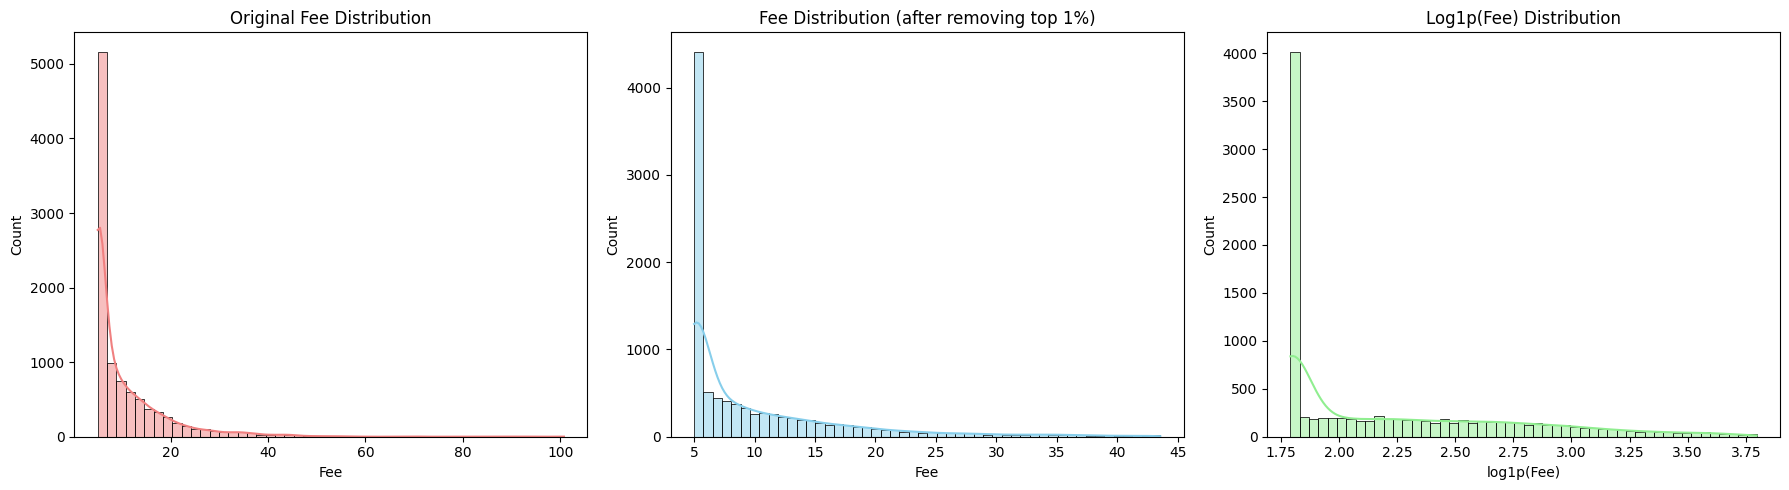

Fee skewness (before outlier removal): 3.07
Fee skewness (after outlier removal): 1.97
Log1p(Fee) skewness (after outlier removal): 0.98


In [93]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original fee distribution (before outlier removal)
sns.histplot(original_uber_data['fee'], bins=50, kde=True, ax=axes[0], color='lightcoral')
axes[0].set_title('Original Fee Distribution')
axes[0].set_xlabel('Fee')
axes[0].set_ylabel('Count')

# Fee distribution after outlier removal
sns.histplot(uber_data['fee'], bins=50, kde=True, ax=axes[1], color='skyblue')
axes[1].set_title(f'Fee Distribution (after removing top 1%)')
axes[1].set_xlabel('Fee')
axes[1].set_ylabel('Count')

# Log-transformed fee distribution
sns.histplot(np.log1p(uber_data['fee']), bins=50, kde=True, ax=axes[2], color='lightgreen')
axes[2].set_title('Log1p(Fee) Distribution')
axes[2].set_xlabel('log1p(Fee)')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

print(f"Fee skewness (before outlier removal): {original_uber_data['fee'].skew():.2f}")
print(f"Fee skewness (after outlier removal): {uber_data['fee'].skew():.2f}")
print(f"Log1p(Fee) skewness (after outlier removal): {np.log1p(uber_data['fee']).skew():.2f}")

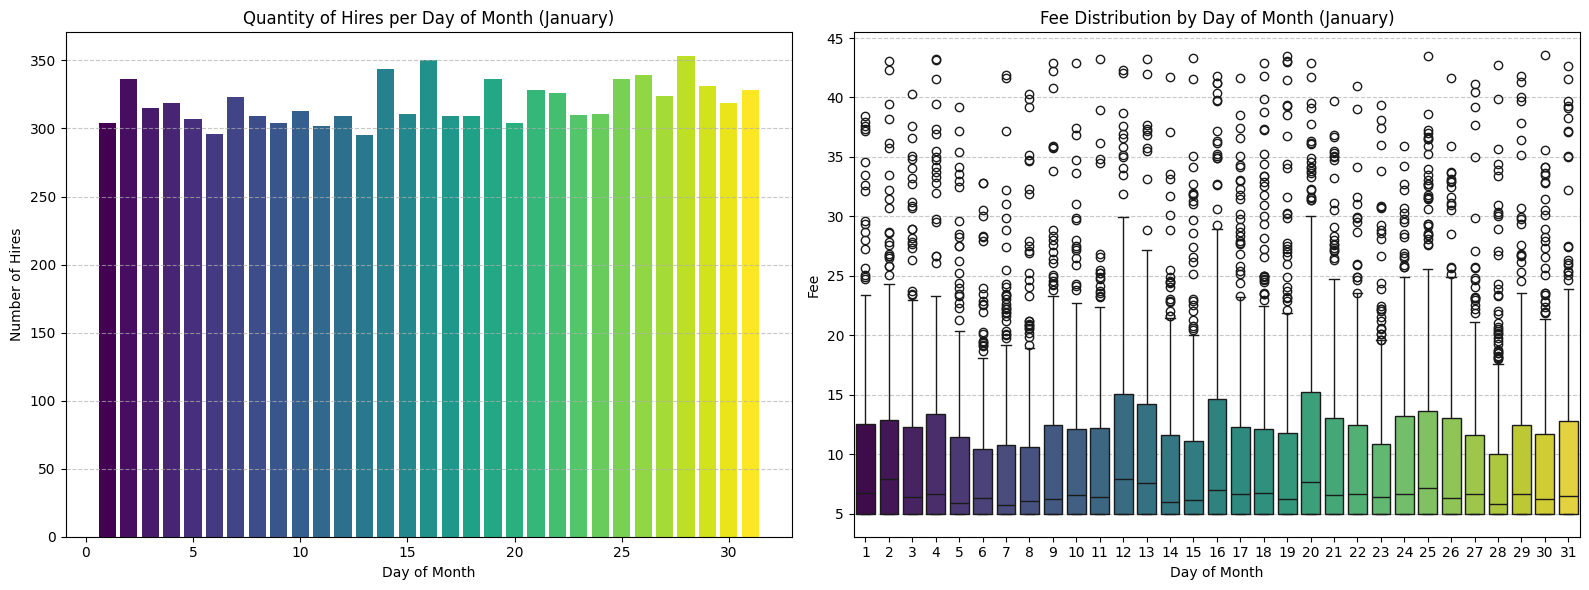

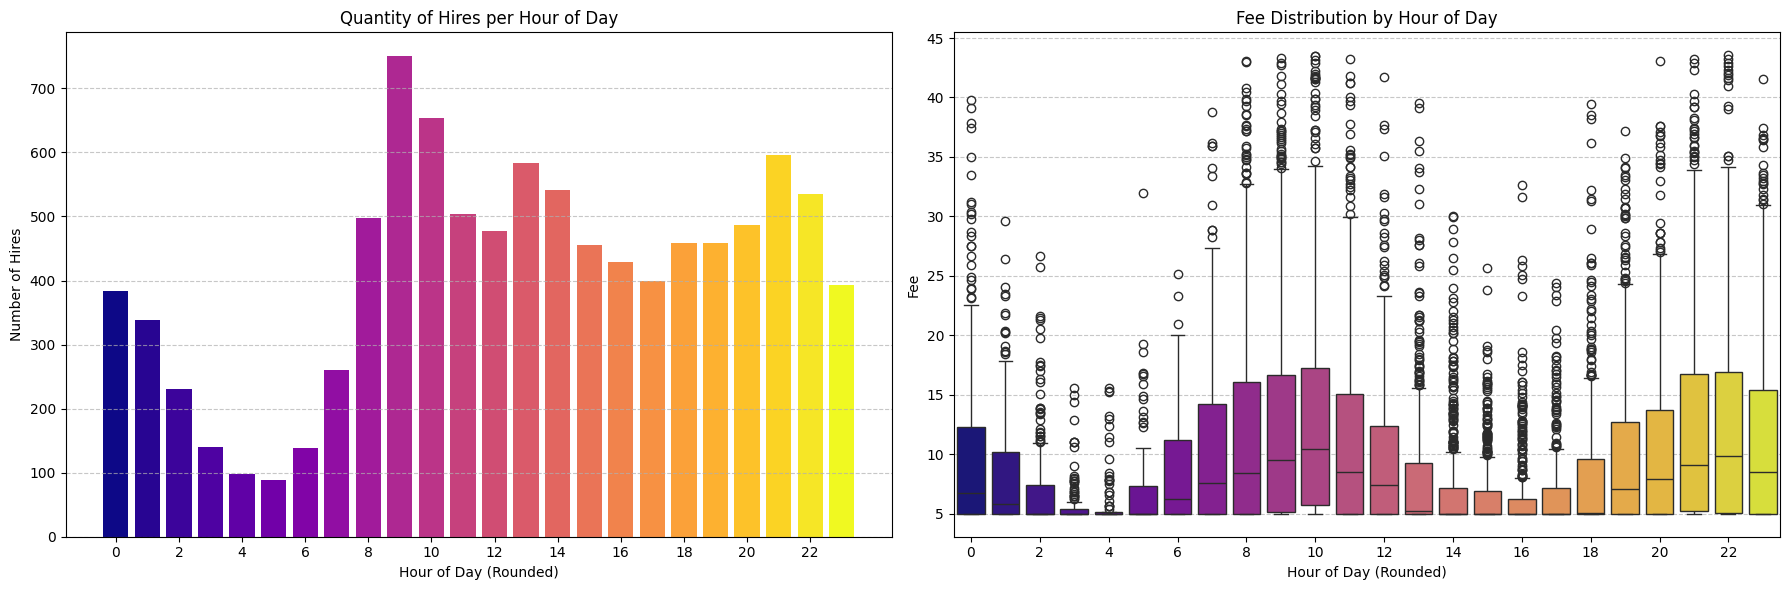

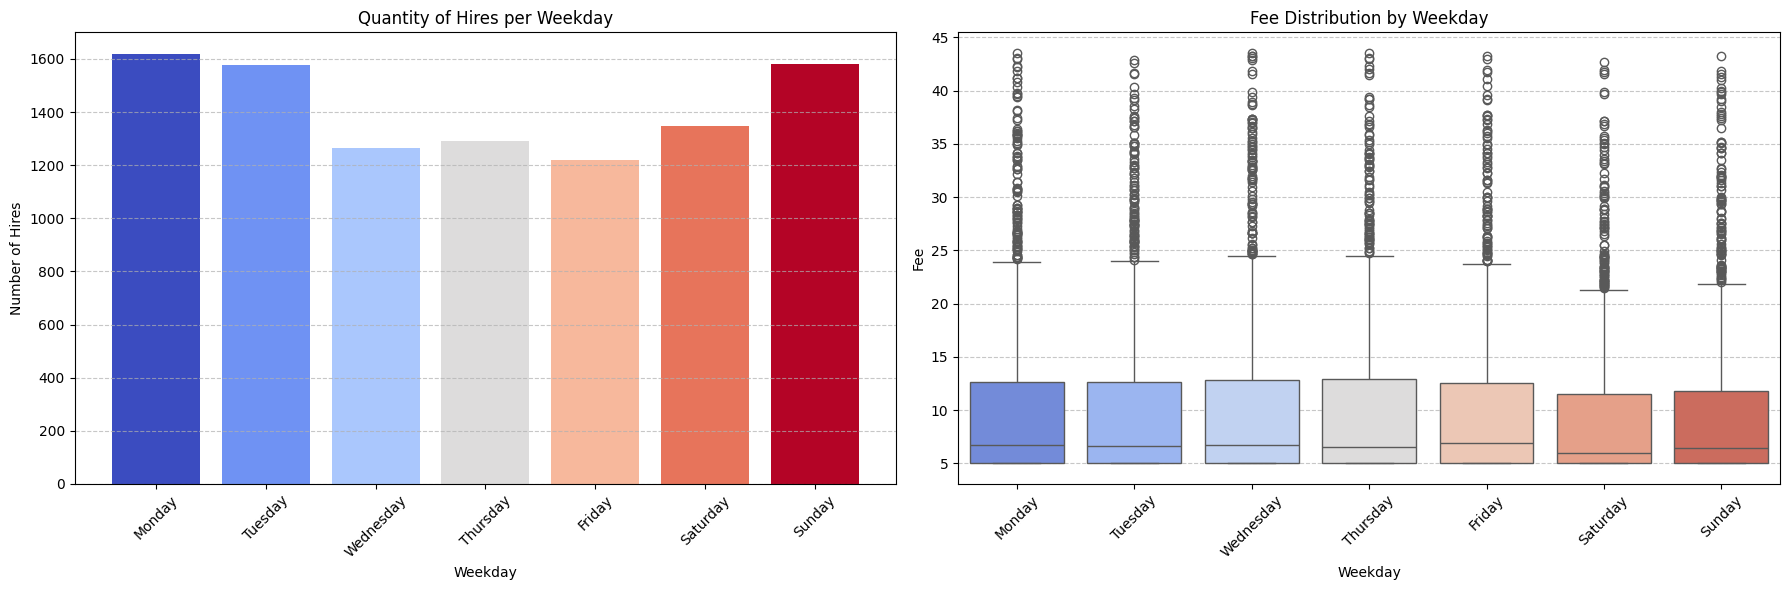

In [94]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# --- 1. Quantity of Hires & Fee Distribution per DAY ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Quantity of hire per Day (Bar Plot)
hire_per_day = uber_data['day'].value_counts().sort_index()
# Use matplotlib directly for bar plot to avoid seaborn warnings
axes[0].bar(hire_per_day.index, hire_per_day.values, color=plt.cm.viridis(np.linspace(0, 1, len(hire_per_day))))
axes[0].set_title('Quantity of Hires per Day of Month (January)')
axes[0].set_xlabel('Day of Month')
axes[0].set_ylabel('Number of Hires')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Fee Distribution by Day of Month (Box Plot)
# For boxplot, use the recommended approach: assign x to hue and set legend=False
sns.boxplot(x='day', y='fee', data=uber_data, ax=axes[1], 
            hue='day', palette='viridis', legend=False)
axes[1].set_title('Fee Distribution by Day of Month (January)')
axes[1].set_xlabel('Day of Month')
axes[1].set_ylabel('Fee')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# --- 2. Quantity of Hires & Fee Distribution per HOUR ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Quantity of hire per Hour (Bar Plot)
hire_per_hour = uber_data['hour'].value_counts().sort_index()
# Use matplotlib directly for bar plot to avoid seaborn warnings
axes[0].bar(hire_per_hour.index, hire_per_hour.values, color=plt.cm.plasma(np.linspace(0, 1, len(hire_per_hour))))
axes[0].set_title('Quantity of Hires per Hour of Day')
axes[0].set_xlabel('Hour of Day (Rounded)')
axes[0].set_ylabel('Number of Hires')
axes[0].set_xticks(range(0, 24, 2))  # Show every other hour tick for readability
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Fee Distribution by Hour (Box Plot)
# For boxplot, use the recommended approach: assign x to hue and set legend=False
sns.boxplot(x='hour', y='fee', data=uber_data, ax=axes[1], 
            hue='hour', palette='plasma', legend=False)
axes[1].set_title('Fee Distribution by Hour of Day')
axes[1].set_xlabel('Hour of Day (Rounded)')
axes[1].set_ylabel('Fee')
axes[1].set_xticks(range(0, 24, 2))  # Show every other hour tick for readability
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# --- 3. Quantity of Hires & Fee Distribution per WEEKDAY ---
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 1: Quantity of hire per Weekday (Bar Plot)
hire_per_weekday = uber_data['weekday'].value_counts().sort_index()
# Use matplotlib directly for bar plot to avoid seaborn warnings
axes[0].bar(hire_per_weekday.index, hire_per_weekday.values, color=plt.cm.coolwarm(np.linspace(0, 1, len(hire_per_weekday))))
axes[0].set_title('Quantity of Hires per Weekday')
axes[0].set_xlabel('Weekday')
axes[0].set_ylabel('Number of Hires')
axes[0].tick_params(axis='x', rotation=45)  # Rotate labels for readability
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Fee Distribution by Weekday (Box Plot)
# For boxplot, use the recommended approach: assign x to hue and set legend=False
sns.boxplot(x='weekday', y='fee', data=uber_data, ax=axes[1], 
            hue='weekday', palette='coolwarm', legend=False)
axes[1].set_title('Fee Distribution by Weekday')
axes[1].set_xlabel('Weekday')
axes[1].set_ylabel('Fee')
axes[1].tick_params(axis='x', rotation=45)  # Rotate labels for readability
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

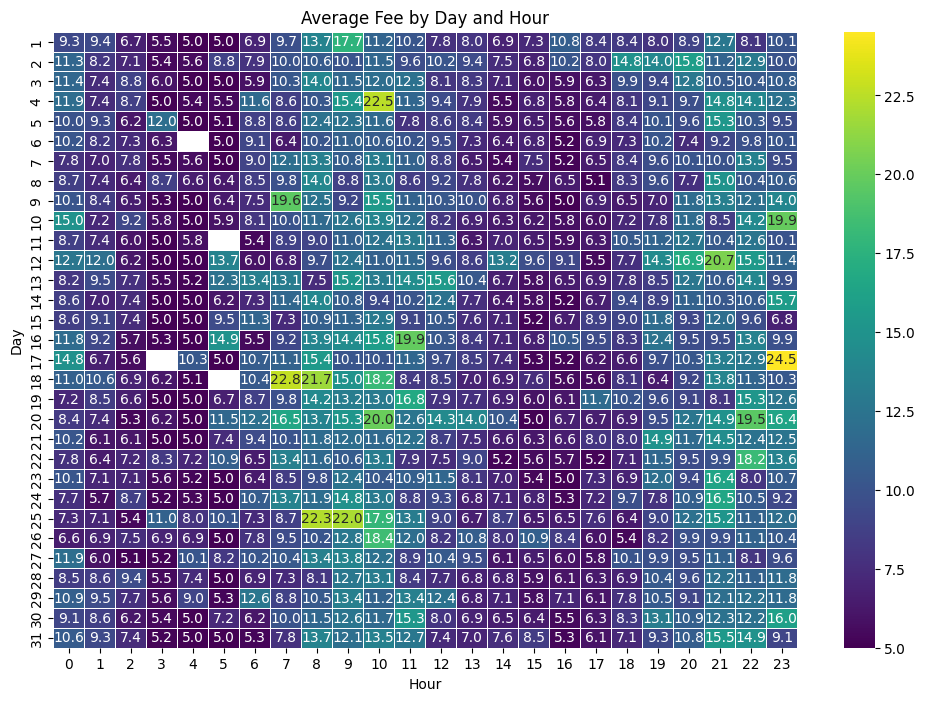

In [95]:
hourly_daily_fee = uber_data.groupby(['day', 'hour'])['fee'].mean().unstack()
plt.figure(figsize=(12, 8))
sns.heatmap(hourly_daily_fee, cmap='viridis', annot=True, fmt=".1f", linewidths=.5)
plt.title('Average Fee by Day and Hour')
plt.ylabel('Day')
plt.xlabel('Hour')
plt.show()

## Temporal Observations & Pricing Insights

1.  **Hourly Dynamics Dominate:**
    * **Demand:** Rides peak during morning (8 AM) and evening (5-6 PM) commutes.
    * **Afternoon Dip:** 1-4 PM consistently shows the **lowest median fees**, indicating balanced supply and demand.

2.  **Day of Month: Minimal Impact:**
    * Within January, the specific day of the month shows **little variation** in either total hires or fee distributions, suggesting its minor role compared to hourly and weekly cycles.

The **heatmap** strongly confirms that hourly patterns, particularly the early morning/late night and morning rush, are the primary drivers of average fee fluctuations, with a notable consistent premium on Mondays mornings and throughout weekend hours. The mid-afternoon period generally offers the lowest average fares.

# 5. Merging Weather Data

In [96]:
meteo['timestamp'] = pd.to_datetime(meteo['timestamp'])
print(f"Meteo data shape BEFORE dropping NaNs: {meteo.shape}")
meteo.dropna(inplace=True)
print(f"Meteo data shape AFTER dropping NaNs: {meteo.shape}")
meteo['day'] = meteo['timestamp'].dt.day
meteo['hour'] = meteo['timestamp'].dt.round('H').dt.hour


meteo_to_merge = meteo[['day', 'hour', 'rain_level', 'temperature']]
uber_data['day'] = uber_data['datetime'].dt.day
uber_data['hour'] = uber_data['datetime'].dt.round('H').dt.hour
uber_data = uber_data.merge(meteo_to_merge, on=['day', 'hour'], how='left')
print("\nMissing weather data after merge:")
print(uber_data[['rain_level', 'temperature']].isnull().sum())
# Fill NaN rain_level with 0 (assuming no record means no rain)
uber_data['rain_level'] = uber_data['rain_level'].fillna(0)

# Fill NaN temperature with the mean temperature
mean_temp = uber_data['temperature'].mean()
uber_data['temperature'] = uber_data['temperature'].fillna(mean_temp)

# Convert to int after handling NaNs
uber_data['rain_level'] = uber_data['rain_level'].astype(int)
uber_data['temperature'] = uber_data['temperature'].astype(int)

print("\nUber data head after merging weather and cleaning:")
print(uber_data.head())

Meteo data shape BEFORE dropping NaNs: (744, 3)
Meteo data shape AFTER dropping NaNs: (744, 3)

Missing weather data after merge:
rain_level     0
temperature    0
dtype: int64

Uber data head after merging weather and cleaning:
             timestamp                               raw_start_location  \
0  2023-01-18 22:21:35      145, Rue Belliard, Paris 18e Arrondissement   
1  2023-01-19 20:31:27  127, Rue de Charenton, Paris 12e Arrondissement   
2  2023-01-25 19:40:10  8, Rue Richard Lenoir, Paris 11e Arrondissement   
3  2023-01-14 10:07:15         6, Rue Guisarde, Paris 6e Arrondissement   
4  2023-01-01 21:23:11      2, Rue Cognacq-Jay, Paris 7e Arrondissement   

                                    raw_end_location    fee  \
0    315, Rue de Charenton, Paris 12e Arrondissement  16.57   
1  1, Square de la Dordogne, Paris 17e Arrondisse...  18.61   
2      9, Rue de Cherbourg, Paris 15e Arrondissement  13.15   
3          28, Rue Guynemer, Paris 6e Arrondissement   5.00   
4  11

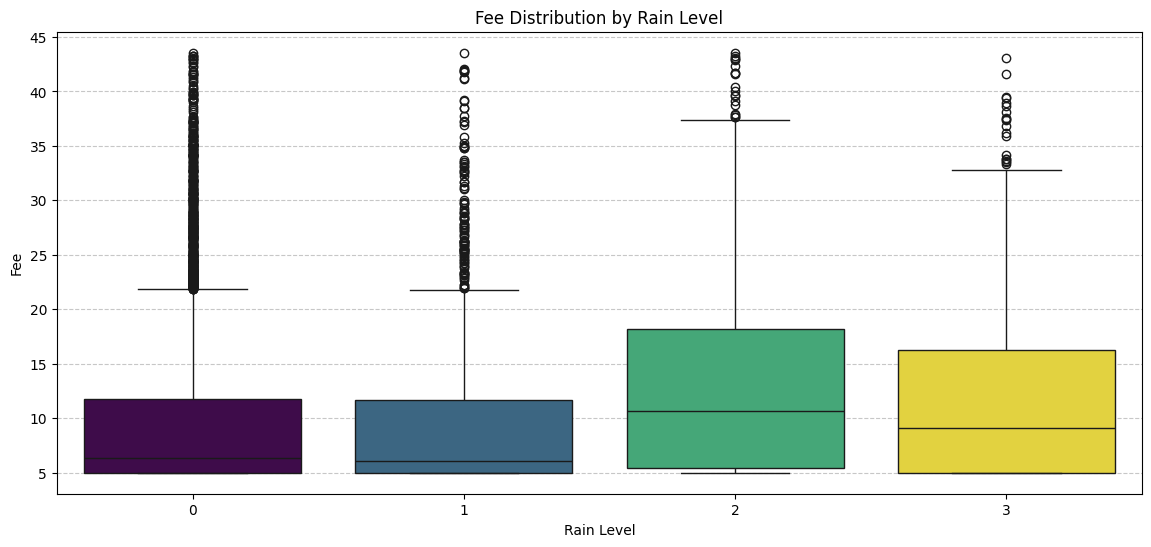

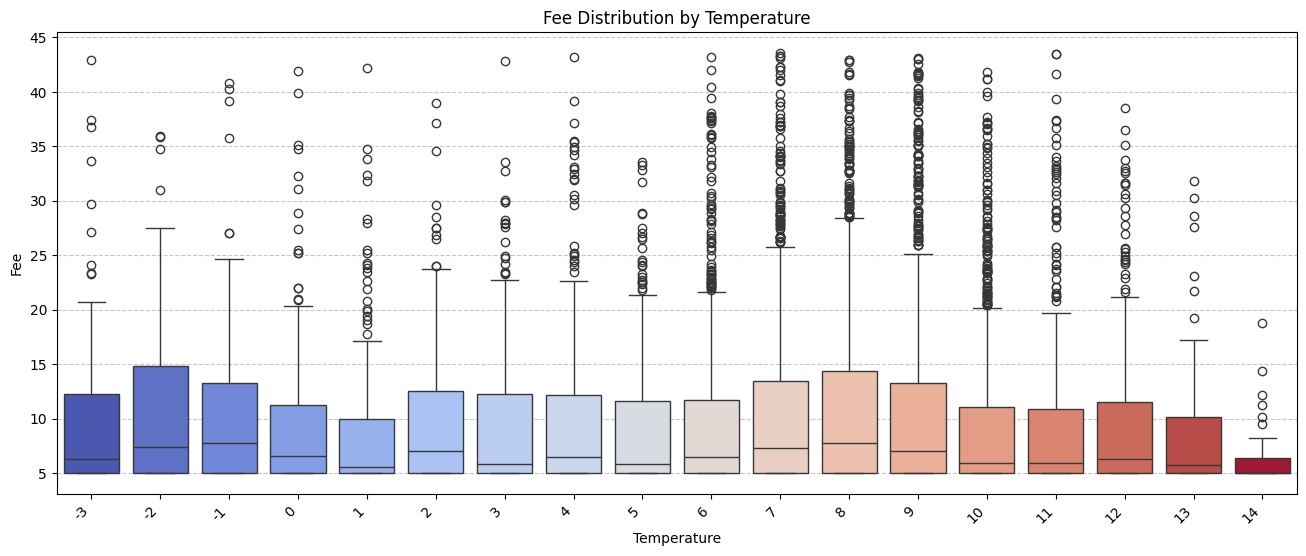

In [ ]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='rain_level', y='fee', data=uber_data, palette='viridis', hue='rain_level', legend=False)
plt.title('Fee Distribution by Rain Level')
plt.xlabel('Rain Level')
plt.ylabel('Fee')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(16, 6))
sns.boxplot(x='temperature', y='fee', data=uber_data, palette='coolwarm', hue='temperature', legend=False)
plt.title('Fee Distribution by Temperature')
plt.xlabel('Temperature')
plt.ylabel('Fee')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels if they overlap
plt.show()

## Observations on Weather vs. Fee

**rain level shows a clear positive correlation with higher Uber fees**, suggesting surge pricing during adverse weather. **Temperature, however, seems to have a less direct or consistent impact on average fees**, with only minor fluctuations in median prices across its observed range.

In [ ]:
# Create a column 'location' with an adress format similar to uber_data

# 'rep' are considered only when != NaN
paris_adress_info['location'] = paris_adress_info['numero'].astype(str) + paris_adress_info['rep'].fillna('').astype(str) + ", " + paris_adress_info['nom_voie'] + ", "+ paris_adress_info['nom_commune']
paris_adress_coord = paris_adress_info[['location', 'x', 'y', 'lon', 'lat']]
print(paris_adress_coord.isnull().sum())
rows_with_nan = paris_adress_coord[paris_adress_coord.isnull().any(axis=1)]
print(rows_with_nan)
paris_adress_coord.duplicated(subset=['location']).sum()
paris_adress_coord.info()
paris_adress_coord.head()

location    0
x           0
y           0
lon         0
lat         0
dtype: int64
Empty DataFrame
Columns: [location, x, y, lon, lat]
Index: []
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158048 entries, 0 to 158047
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   location  158048 non-null  object 
 1   x         158048 non-null  float64
 2   y         158048 non-null  float64
 3   lon       158048 non-null  float64
 4   lat       158048 non-null  float64
dtypes: float64(4), object(1)
memory usage: 6.0+ MB


,location,x,y,lon,lat
0,"1, Avenue du Général Lemonnier, Paris 1er Arro...",650852.91,6862571.27,2.330113,48.861299
1,"2, Avenue du Général Lemonnier, Paris 1er Arro...",650873.96,6862544.40,2.330403,48.861059
2,"3, Avenue du Général Lemonnier, Paris 1er Arro...",650864.26,6862595.30,2.330265,48.861516
3,"4, Avenue du Général Lemonnier, Paris 1er Arro...",650884.77,6862565.22,2.330548,48.861247
4,"5, Avenue du Général Lemonnier, Paris 1er Arro...",650876.06,6862619.33,2.330423,48.861733


In [ ]:
# print(paris_adress_info.loc[(paris_adress_info['numero'] == 5) & (paris_adress_info['nom_voie'] == 'Rue Bois le Vent')])
# print(paris_adress_info.loc[paris_adress_info['nom_voie'] == 'Rue Bois le Vent'])
# print(paris_adress_info.loc[paris_adress_info['nom_voie'] == 'Rue de Bretagne'])
# print(paris_adress_info.loc[(paris_adress_info['numero'] == 5) & (paris_adress_info['nom_voie'] == 'Rue Bois le Vent')])
# 28, Rue Levert, Paris 20e Arrondissement
# 5, Rue Bois le Vent, Paris 16e Arrondissement

In [ ]:
"""
Warning: 'uber_data' adresses uses curly apostrophe (not part of the standard ASCII character set) instead of simple apostrophe like in 
paris_adresse_info dtf.
Likely the CSV is encoded with UTF-8 (8 bits, standard ASCII) but effectively everything is ASCII until you hit the curly quotes and things go off the 
rails.
"""
# print(paris_adress_info.loc[(paris_adress_info['numero'] == 65) & (paris_adress_info['nom_voie'] == 'Rue de l’Ouest')])
# print(paris_adress_info.loc[(paris_adress_info['numero'] == 65) & (paris_adress_info['nom_voie'] == 'Rue de l\'Ouest')])
# print(paris_adress_info.loc[(paris_adress_info['nom_voie'] == 'Rue de l’Ouest')])
# print(paris_adress_coord.query('location == "25, Rue Decamps, Paris 16e Arrondissement"'))
# 25, Rue Decamps, Paris 16e Arrondissement
# 65, Rue de l’Ouest, Paris 14e Arrondissement

def replace_curly_apostrophes(text):
    """Replaces curly apostrophes with straight apostrophes.
    Args:
        text (str): The input text.
    Returns:
        str: The text with curly apostrophes replaced.
    """
    return text.replace("’", "'")

uber_data['raw_start_location'] = uber_data['raw_start_location'].apply(replace_curly_apostrophes)
uber_data['raw_end_location'] = uber_data['raw_end_location'].apply(replace_curly_apostrophes)


In [ ]:
# Add the spatial data to our main dtf
"""
Note: Inner Join Can Increase Rows because of duplicate keys ! If a key value appears multiple times in one or both DataFrames, the resulting merged 
DataFrame will have multiple rows for each duplicate key combination. Check for duplicates in both dataframe first.
"""
# Make it case insensitivity
uber_data['raw_start_location'] = uber_data['raw_start_location'].str.lower()
uber_data['raw_end_location'] = uber_data['raw_end_location'].str.lower()
paris_adress_coord['location'] = paris_adress_coord['location'].str.lower()

merged_df = uber_data.merge(paris_adress_coord, left_on='raw_start_location', right_on='location', how='inner')
merged_df = merged_df.merge(paris_adress_coord, left_on='raw_end_location', right_on='location', how='inner')
merged_df.info()
"""
Not every adress from 'uber_data' seems to be present in 'paris_adress_coord': We lose a lot of informations. Some adresses are missing but for some
the problem comes from certains mistakes in the adresses of 'uber_data' like 'Quai de l'Hôtel de Ville' named 'Rue de l'Hôtel de Ville'.
"""
# print(merged_df.isnull().sum())
# rows_with_nan = merged_df[merged_df.isnull().any(axis=1)]
# print(rows_with_nan)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9797 entries, 0 to 9796
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   timestamp_x         9797 non-null   object        
 1   raw_start_location  9797 non-null   object        
 2   raw_end_location    9797 non-null   object        
 3   fee                 9797 non-null   float64       
 4   datetime            9797 non-null   datetime64[ns]
 5   day                 9797 non-null   int32         
 6   hour                9797 non-null   int64         
 7   weekday             9797 non-null   int64         
 8   timestamp_y         9797 non-null   object        
 9   rain_level          9797 non-null   int32         
 10  temperature         9797 non-null   int32         
 11  location_x          9797 non-null   object        
 12  x_x                 9797 non-null   float64       
 13  y_x                 9797 non-null   float64     

C:\Users\Utilisateur\AppData\Local\Temp\ipykernel_32748\1998926255.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  paris_adress_coord['location'] = paris_adress_coord['location'].str.lower()


"\nNot every adress from 'uber_data' seems to be present in 'paris_adress_coord': We lose a lot of informations. Some adresses are missing but for some\nthe problem comes from certains mistakes in the adresses of 'uber_data' like 'Quai de l'Hôtel de Ville' named 'Rue de l'Hôtel de Ville'.\n"

In [ ]:
merged_df.head()

,timestamp_x,raw_start_location,raw_end_location,fee,datetime,day,hour,weekday,timestamp_y,rain_level,...,location_x,x_x,y_x,lon_x,lat_x,location_y,x_y,y_y,lon_y,lat_y
0,2023-01-18 22:21:35,"145, rue belliard, paris 18e arrondissement","315, rue de charenton, paris 12e arrondissement",16.57,2023-01-18 22:21:35,18,22,3,2023-01-18 22:00:00,0,...,"145, rue belliard, paris 18e arrondissement",651135.58,6866436.68,2.333521,48.896081,"315, rue de charenton, paris 12e arrondissement",655601.50,6859456.32,2.395160,48.833631
1,2023-01-19 20:31:27,"127, rue de charenton, paris 12e arrondissement","1, square de la dordogne, paris 17e arrondisse...",18.61,2023-01-19 20:31:27,19,21,4,2023-01-19 21:00:00,0,...,"127, rue de charenton, paris 12e arrondissement",654544.56,6860793.65,2.380619,48.845584,"1, square de la dordogne, paris 17e arrondisse...",648668.21,6865621.23,2.299968,48.888556
2,2023-01-25 19:40:10,"8, rue richard lenoir, paris 11e arrondissement","9, rue de cherbourg, paris 15e arrondissement",13.15,2023-01-25 19:40:10,25,20,3,2023-01-25 20:00:00,0,...,"8, rue richard lenoir, paris 11e arrondissement",654681.23,6861809.48,2.382373,48.854729,"9, rue de cherbourg, paris 15e arrondissement",648935.23,6859256.02,2.304374,48.831336
3,2023-01-14 10:07:15,"6, rue guisarde, paris 6e arrondissement","28, rue guynemer, paris 6e arrondissement",5.00,2023-01-14 10:07:15,14,10,6,2023-01-14 10:00:00,0,...,"6, rue guisarde, paris 6e arrondissement",651179.85,6861527.13,2.334689,48.851934,"28, rue guynemer, paris 6e arrondissement",650998.16,6860928.97,2.332282,48.846541
4,2023-01-01 21:23:11,"2, rue cognacq-jay, paris 7e arrondissement","115, boulevard du montparnasse, paris 6e arron...",5.00,2023-01-01 21:23:11,1,21,0,2023-01-01 21:00:00,0,...,"2, rue cognacq-jay, paris 7e arrondissement",649022.81,6862643.13,2.305161,48.861803,"115, boulevard du montparnasse, paris 6e arron...",650826.33,6860433.81,2.329998,48.842075


In [ ]:
# Add 'start_Arrondissement' and 'end_Arrondissement' columns

merged_df['start_arrondissement'] = merged_df['location_x'].str.extract(r'(\d+)(?:e|er) arrondissement').astype(int)  # (\d+)e does not cover 1er arr
merged_df['end_arrondissement'] = merged_df['location_y'].str.extract(r'(\d+)(?:e|er) arrondissement').astype(int)
# rows_with_nan = merged_df[merged_df.isnull().any(axis=1)]
# print(rows_with_nan)
#merged_df.info()
#merged_df.head()

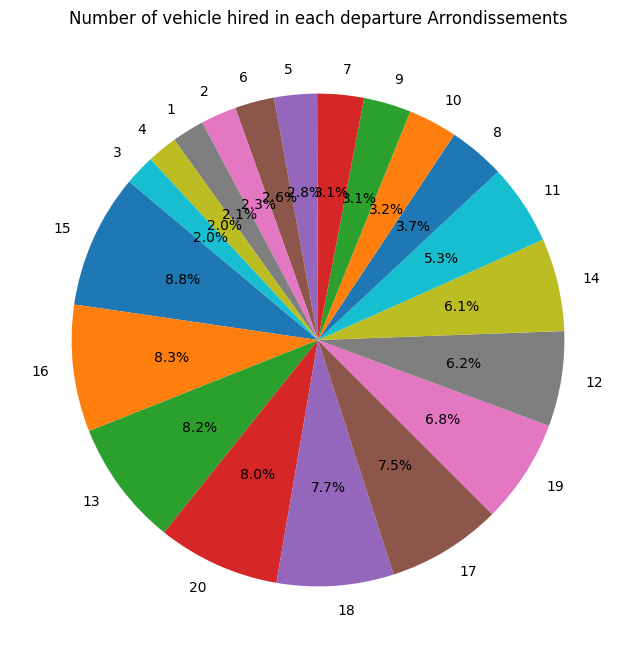

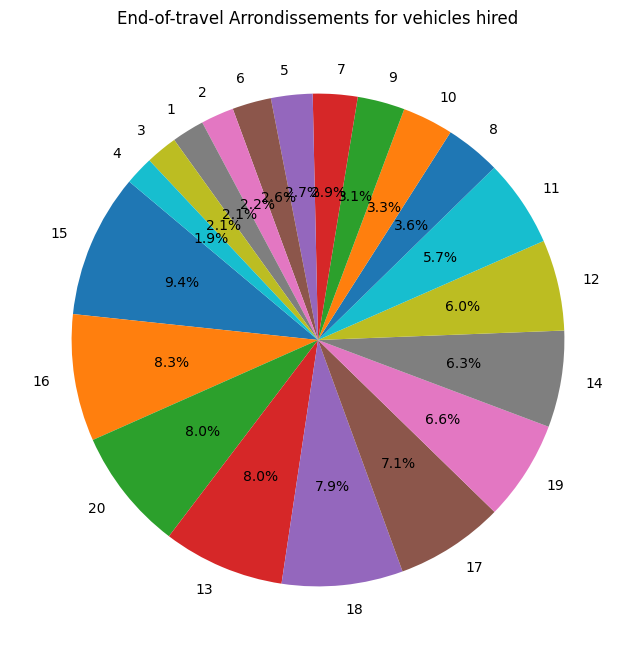

In [ ]:
start_arr_counts = merged_df['start_arrondissement'].value_counts()
end_arr_counts = merged_df['end_arrondissement'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(start_arr_counts, labels=start_arr_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Number of vehicle hired in each departure Arrondissements')
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(end_arr_counts, labels=end_arr_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('End-of-travel Arrondissements for vehicles hired')
plt.show()

<Axes: xlabel='end_arrondissement', ylabel='start_arrondissement'>

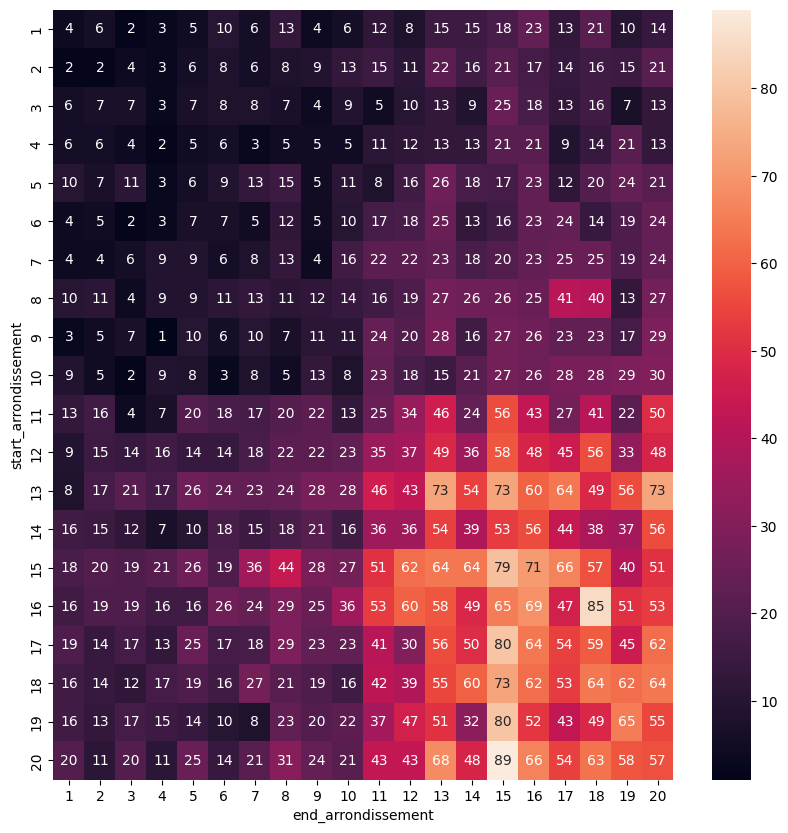

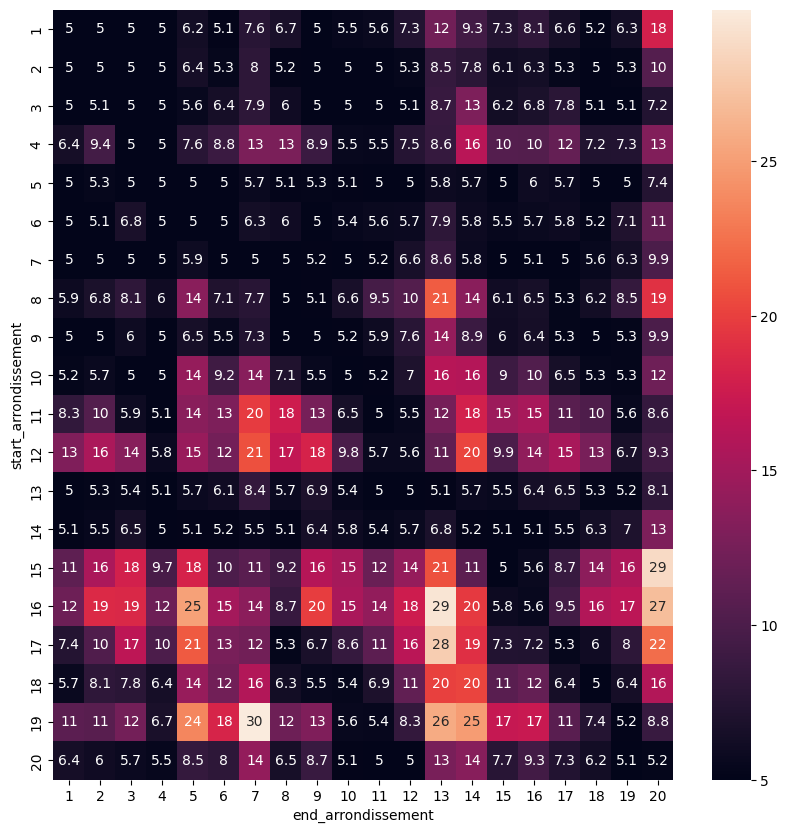

In [ ]:
# merged_df['arr-to-arr'] = merged_df['start_Arrondissement'] + " to " + merged_df['end_Arrondissement']
"""
Create a pivot table to count occurrences:
merged_df.groupby(['start_Arrondissement', 'end_Arrondissement']).size(): Groups the DataFrame by 'start_Arrondissement' and 'end_Arrondissement' and counts 
the occurrences of each combination. Function 'groupby.size()' = return the number of rows in each group as a Series or dtf).
.unstack(fill_value=0): Reshapes the grouped DataFrame into a pivot table, using 'start_Arrondissement' as the index and 'end_Arrondissement' as the 
column names. Missing combinations are filled with 0.
This pivot table 'df_arr' represents the desired output, where the index values are unique 'start_Arrondissement' values, the column names are unique 
'end_Arrondissement' values, and the cell values indicate the number of times that specific 'start_Arrondissement' and 'end_Arrondissement' combination 
occurred in the original DataFrame.
"""
df_arr = merged_df.groupby(['start_arrondissement', 'end_arrondissement']).size().unstack(fill_value=0)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_arr, annot=True, ax=ax, fmt="d")  # fmt="d" to avoid scientific notation of big numbers
"""
Create a pivot table to calculate the sum of 'fee' for each combination of 'start_Arrondissement' and 'end_Arrondissement':
index='start_Arrondissement': The rows of the pivot table are indexed by the unique values in the 'start_Arrondissement' column.
columns='end_Arrondissement': The columns of the pivot table are indexed by the unique values in the 'end_Arrondissement' column.
values='fee': The values in the pivot table are the sum of the 'fee' values for each combination of 'start_Arrondissement' and 'end_Arrondissement'.
"""
# Create a pivot table to calculate the sum of 'fee' for each combination of 'start_Arrondissement' and 'end_Arrondissement'
df_fee_arr = merged_df.pivot_table(index='start_arrondissement', columns='end_arrondissement', values='fee', aggfunc='mean')
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(df_fee_arr, annot=True, ax=ax)

In [ ]:
import geopy.distance
merged_df['distance']=[round(geopy.distance.distance((merged_df.lat_x[i], merged_df.lon_x[i]),(merged_df.lat_y[i], merged_df.lon_y[i])).m,1) for i in merged_df.index]
merged_df.head()

,timestamp_x,raw_start_location,raw_end_location,fee,datetime,day,hour,weekday,timestamp_y,rain_level,...,lon_x,lat_x,location_y,x_y,y_y,lon_y,lat_y,start_arrondissement,end_arrondissement,distance
0,2023-01-18 22:21:35,"145, rue belliard, paris 18e arrondissement","315, rue de charenton, paris 12e arrondissement",16.57,2023-01-18 22:21:35,18,22,3,2023-01-18 22:00:00,0,...,2.333521,48.896081,"315, rue de charenton, paris 12e arrondissement",655601.50,6859456.32,2.395160,48.833631,18,12,8287.6
1,2023-01-19 20:31:27,"127, rue de charenton, paris 12e arrondissement","1, square de la dordogne, paris 17e arrondisse...",18.61,2023-01-19 20:31:27,19,21,4,2023-01-19 21:00:00,0,...,2.380619,48.845584,"1, square de la dordogne, paris 17e arrondisse...",648668.21,6865621.23,2.299968,48.888556,12,17,7605.8
2,2023-01-25 19:40:10,"8, rue richard lenoir, paris 11e arrondissement","9, rue de cherbourg, paris 15e arrondissement",13.15,2023-01-25 19:40:10,25,20,3,2023-01-25 20:00:00,0,...,2.382373,48.854729,"9, rue de cherbourg, paris 15e arrondissement",648935.23,6859256.02,2.304374,48.831336,11,15,6288.6
3,2023-01-14 10:07:15,"6, rue guisarde, paris 6e arrondissement","28, rue guynemer, paris 6e arrondissement",5.00,2023-01-14 10:07:15,14,10,6,2023-01-14 10:00:00,0,...,2.334689,48.851934,"28, rue guynemer, paris 6e arrondissement",650998.16,6860928.97,2.332282,48.846541,6,6,625.2
4,2023-01-01 21:23:11,"2, rue cognacq-jay, paris 7e arrondissement","115, boulevard du montparnasse, paris 6e arron...",5.00,2023-01-01 21:23:11,1,21,0,2023-01-01 21:00:00,0,...,2.305161,48.861803,"115, boulevard du montparnasse, paris 6e arron...",650826.33,6860433.81,2.329998,48.842075,7,6,2852.3


              fee  distance
fee       1.00000   0.50181
distance  0.50181   1.00000


<Axes: title={'center': 'Fee vs Distance (m)'}, xlabel='distance', ylabel='fee'>

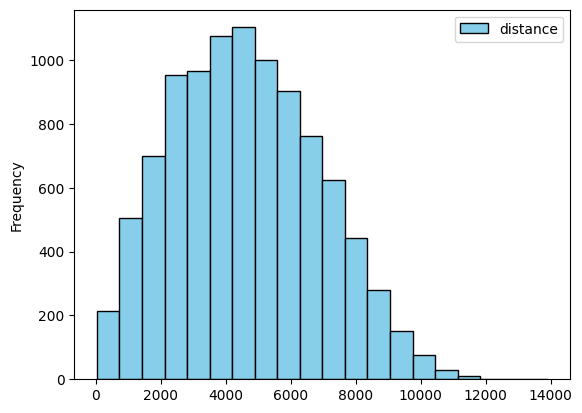

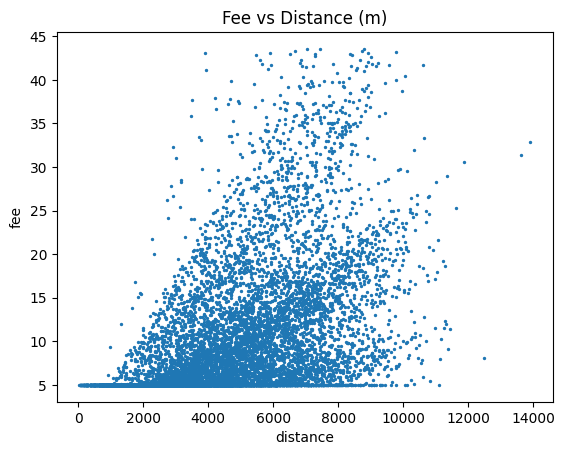

In [ ]:
# Correlation: fee with distances
print(merged_df[['fee', 'distance']].corr())

merged_df.plot(kind = "hist",y = "distance", bins= 20, range = (merged_df['distance'].astype(int).min(), merged_df['distance'].astype(int).max()), color='skyblue', edgecolor='black')

merged_df.plot.scatter(x='distance', y='fee', title='Fee vs Distance (m)', s=2)

In [ ]:
# Print some correlations
print(merged_df[['fee', 'hour', 'rain_level', 'temperature', 'start_arrondissement',	'end_arrondissement', 'weekday', 'x_x', 'y_x', 'lon_x', 
                 'lat_x', 'x_y', 'y_y', 'lon_y', 'lat_y', 'distance']].corr())
# corr_matrix["fee"].sort_values(ascending=False)
"""
Observations:
- x and y have correlation of 1 with longitude and latitude
- fee is highly correlated with distance
- fee varies only slightly with 'temperature' or 'weekday'
"""

                           fee      hour  rain_level  temperature  \
fee                   1.000000  0.049187    0.141473    -0.003673   
hour                  0.049187  1.000000    0.028412     0.093581   
rain_level            0.141473  0.028412    1.000000     0.120482   
temperature          -0.003673  0.093581    0.120482     1.000000   
start_arrondissement  0.208015  0.019994   -0.019262    -0.005307   
end_arrondissement    0.014057 -0.008168   -0.003770    -0.004058   
weekday              -0.006030 -0.012443    0.028027     0.027413   
x_x                  -0.155478 -0.004120    0.004425    -0.002429   
y_x                   0.125343  0.002545   -0.003923    -0.000361   
lon_x                -0.156345 -0.004135    0.004452    -0.002425   
lat_x                 0.123579  0.002502   -0.003865    -0.000385   
x_y                   0.084194  0.005984   -0.015056    -0.007302   
y_y                  -0.226185 -0.002701    0.005617     0.004802   
lon_y                 0.085738  0.

"\nObservations:\n- x and y have correlation of 1 with longitude and latitude\n- fee is highly correlated with distance\n- fee varies only slightly with 'temperature' or 'weekday'\n"

In [ ]:
# Feature selection
"""
Multiple regression problem since we will use multiple features to make a prediction.
It is also a univariate regression problem since we are only trying to predict a single value for each ride in our case.
"""
## One-hot encoding of weekday because values of 0 and 6 are closer than 4 and 6. Same for hours as 0 and 23 are closer than 20 and 23.
# clean_dataset = pd.get_dummies(
#     merged_df, 
#     columns= ['hour', 'start_arrondissement', 'end_arrondissement'], # 'weekday',
#     prefix=['hour', 'start_arr', 'end_arr'], # 'weekday', 
#     dtype=int
# )
# clean_dataset = clean_dataset.drop(['timestamp_x','timestamp_y','raw_start_location','raw_end_location','datetime','day','location_x','location_y','x_x', 
#                              'y_x', 'x_y', 'y_y', 'weekday'], axis=1)  # 'weekday'
clean_dataset = merged_df.drop(['timestamp_x','timestamp_y','raw_start_location','raw_end_location','datetime','day','location_x','location_y','x_x', 
                              'y_x', 'x_y', 'y_y'], axis=1)  # 'weekday', 'lon_x', 'lat_x', 'lon_y', 'lat_y', 'temperature'
clean_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9797 entries, 0 to 9796
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fee                   9797 non-null   float64
 1   hour                  9797 non-null   int64  
 2   weekday               9797 non-null   int64  
 3   rain_level            9797 non-null   int32  
 4   temperature           9797 non-null   int32  
 5   lon_x                 9797 non-null   float64
 6   lat_x                 9797 non-null   float64
 7   lon_y                 9797 non-null   float64
 8   lat_y                 9797 non-null   float64
 9   start_arrondissement  9797 non-null   int32  
 10  end_arrondissement    9797 non-null   int32  
 11  distance              9797 non-null   float64
dtypes: float64(6), int32(4), int64(2)
memory usage: 765.5 KB


1.9704607242837182
0.3374724604103789


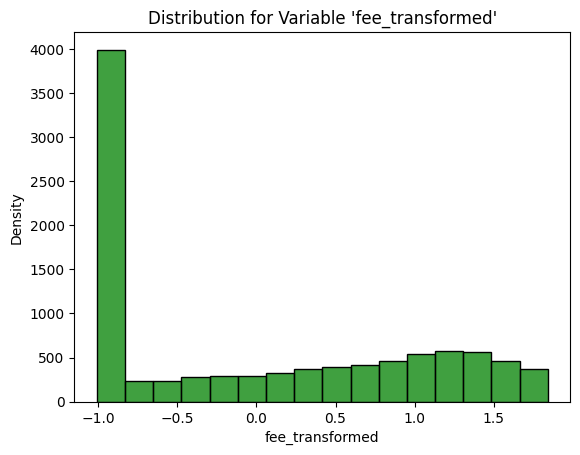

'\nThe transformation is not really convincing, the target variable is still skewed. Not worth to apply the transformation.\n'

In [ ]:
## Split between train/Test
"""
Target variable 'fee' is skewed. We will apply a transformation on it to make it more gaussian.
Another option could have been to categorizes the 'fee' target to then create stratified balanced dataset representating the various categories of fee.
"""
# from sklearn.model_selection import StratifiedShuffleSplit
# clean_dataset["fee_cat"] = pd.cut(clean_dataset["fee"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])
# clean_dataset["fee_cat"].hist()
# split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
# for train_index, test_index in split.split(clean_dataset, clean_dataset["fee_cat"]):
# strat_train_set = clean_dataset.loc[train_index]
# strat_test_set = clean_dataset.loc[test_index]
# strat_test_set["fee_cat"].value_counts() / len(strat_test_set)
print(clean_dataset['fee'].skew())
from sklearn.preprocessing import PowerTransformer
# clean_dataset['fee_transformed'] = np.log1p(clean_dataset['fee'])
# clean_dataset['fee_transformed'] = np.sqrt(clean_dataset['fee'])
clean_dataset['fee_transformed'] = ColumnTransformer([
    ("fee_transform", PowerTransformer(method='box-cox', standardize=True), ['fee'])
]).fit_transform(clean_dataset)  # box-cox  yeo-johnson
# clean_dataset.plot(kind = "hist",y = "fee_transformed", bins= 50, range = (clean_dataset['fee_transformed'].astype(int).min(), clean_dataset['fee_transformed'].astype(int).max()), color='skyblue', edgecolor='black')
print(clean_dataset['fee_transformed'].skew())
sns.histplot(clean_dataset['fee_transformed'],bins='auto',color='green')
plt.title("Distribution for Variable 'fee_transformed'")
plt.ylabel("Density")
plt.show()
"""
The transformation is not really convincing, the target variable is still skewed. Not worth to apply the transformation.
"""

In [ ]:
X = clean_dataset.drop(['fee', 'fee_transformed'], axis=1)  # Features
y = clean_dataset['fee']  # Target variable
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print(x_train.shape)
print(x_test.shape)

(7837, 11)
(1960, 11)


In [ ]:
"""
We quickly test a linear regressor on the data
"""
from sklearn.metrics import mean_squared_error, root_mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(x_train, y_train)
some_data = x_train.iloc[:5]
some_labels = y_train.iloc[:5]

fee_predictions = lin_reg.predict(some_data)
print("Predictions:", fee_predictions)
print("Labels:", list(some_labels))

lin_mse = mean_squared_error(some_labels, fee_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_mse)
print(lin_rmse)

fee_pred = lin_reg.predict(x_test)
print("Predictions:", fee_pred[:10])
print("Labels:", list(y_test[:10]))
print(root_mean_squared_error(y_test, fee_pred))

Predictions: [ 4.47511911 21.02385437  8.94338678  6.74069442  5.33993718]
Labels: [5.0, 20.04, 9.86, 5.0, 5.0]
1.0458447041872885
1.0226654898779408
Predictions: [ 8.45538322  6.06327853  5.22137315  7.20507219  7.4892438   7.61228895
 13.32541015  8.15684424 13.29414983 13.67318327]
Labels: [5.0, 5.0, 5.0, 5.8, 5.0, 5.48, 11.93, 8.83, 9.52, 16.78]
5.198420651626628


# Feature importance analysis

In [170]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance


models = [
    {
        "name": "LinearRegression",
        "model": LinearRegression(),
        "preprocessor": ColumnTransformer([
            ('num', StandardScaler(), [c for c in X.columns if X[c].dtype != 'object']),
            ('cat', OneHotEncoder(handle_unknown='ignore'), [c for c in X.columns if X[c].dtype == 'object'])
        ])
    },
    {
        "name": "KNeighborsRegressor",
        "model": KNeighborsRegressor(),
        "preprocessor": ColumnTransformer([
            ('num', StandardScaler(), [c for c in X.columns if X[c].dtype != 'object']),
            ('cat', OneHotEncoder(handle_unknown='ignore'), [c for c in X.columns if X[c].dtype == 'object'])
        ])
    },
    {
        "name": "SVR",
        "model": SVR(),
        "preprocessor": ColumnTransformer([
            ('num', StandardScaler(), [c for c in X.columns if X[c].dtype != 'object']),
            ('cat', OneHotEncoder(handle_unknown='ignore'), [c for c in X.columns if X[c].dtype == 'object'])
        ])
    },
    {
        "name": "RandomForestRegressor",
        "model": RandomForestRegressor(n_estimators=100, random_state=42),
        "preprocessor": 'passthrough'
    },
    {
        "name": "MLPRegressor",
        "model": MLPRegressor(hidden_layer_sizes=(100,), max_iter=200, random_state=42),
        "preprocessor": ColumnTransformer([
            ('num', StandardScaler(), [c for c in X.columns if X[c].dtype != 'object']),
            ('cat', OneHotEncoder(handle_unknown='ignore'), [c for c in X.columns if X[c].dtype == 'object'])
        ])
    }
]

print("Permutation feature importance for each model:\n")
for cfg in models:
    print(f"=== {cfg['name']} ===")
    steps = []
    if cfg['preprocessor'] != 'passthrough':
        steps.append(('preprocessor', cfg['preprocessor']))
    pipe = Pipeline(steps + [('reg', cfg['model'])])
    pipe.fit(x_train, y_train)
    result = permutation_importance(pipe, x_test, y_test, n_repeats=3, random_state=42)
    if cfg['preprocessor'] != 'passthrough':
        try:
            feature_names = pipe.named_steps['preprocessor'].get_feature_names_out()
        except Exception:
            feature_names = X.columns
    else:
        feature_names = X.columns
    sorted_idx = result.importances_mean.argsort()[::-1]
    for idx in sorted_idx:
        print(f"{feature_names[idx]}: {result.importances_mean[idx]:.4f}")
    print()

Permutation feature importance (top 10) for each model:

=== LinearRegression ===
num__distance: 0.5061
num__lat_y: 0.0879
num__rain_level: 0.0561
num__lat_x: 0.0518
num__lon_y: 0.0512
num__lon_x: 0.0474
num__end_arrondissement: 0.0087
num__start_arrondissement: 0.0076
num__hour: 0.0043
num__temperature: 0.0020
num__weekday: -0.0000

=== KNeighborsRegressor ===
num__distance: 0.2928
num__lat_y: 0.2291
num__lon_x: 0.1678
num__lon_y: 0.1453
num__lat_x: 0.1406
num__start_arrondissement: 0.1108
num__hour: 0.0887
num__end_arrondissement: 0.0712
num__rain_level: 0.0615
num__weekday: 0.0205
num__temperature: 0.0099

=== SVR ===
num__distance: 0.3465
num__lat_y: 0.1120
num__lat_x: 0.1027
num__lon_x: 0.1021
num__start_arrondissement: 0.0952
num__lon_y: 0.0836
num__end_arrondissement: 0.0555
num__rain_level: 0.0421
num__hour: 0.0178
num__temperature: 0.0154
num__weekday: 0.0113

=== RandomForestRegressor ===
distance: 0.6464
hour: 0.2187
start_arrondissement: 0.2152
end_arrondissement: 0.2142
la

c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Summary of Model Results

| Feature                | LinearRegression | KNeighborsRegressor | SVR   | RandomForestRegressor | MLPRegressor | Average Rank (Lower is better) |
| :--------------------- | :--------------- | :------------------ | :---- | :-------------------- | :----------- | :----------------------------- |
| `distance`             | 0.5061           | 0.2928              | 0.3465| 0.6464                | 0.4319       | 1                              |
| `start_arrondissement` | 0.0076           | 0.1108              | 0.0952| 0.2152                | 0.1631       | 2                              |
| `end_arrondissement`   | 0.0087           | 0.0712              | 0.0555| 0.2142                | 0.1967       | 2                              |
| `lat_y` (End Latitude) | 0.0879           | 0.2291              | 0.1120| 0.1197                | 0.3160       | 3                              |
| `hour`                 | 0.0043           | 0.0887              | 0.0178| 0.2187                | 0.1764       | 4                              |
| `lon_y` (End Longitude) | 0.0512          | 0.1453              | 0.0836| 0.0562                | 0.2199       | 5                              |
| `lon_x` (Start Longitude) | 0.0474         | 0.1678              | 0.1021| 0.0744                | 0.2135       | 6                              |
| `lat_x` (Start Latitude) | 0.0518         | 0.1406              | 0.1027| 0.0402                | 0.1624       | 7                              |
| `rain_level`           | 0.0561           | 0.0615              | 0.0421| 0.0796                | 0.0828       | 8                              |
| `weekday`              | -0.0000          | 0.0205              | 0.0113| 0.0008                | 0.0039       | 9                              |
| `temperature`          | 0.0020           | 0.0099              | 0.0154| 0.0008                | 0.0122       | 10                             |

## Summary Table (top features)

| Feature                | Importance (avg, top models) | Comment                              |
|------------------------|------------------------------|--------------------------------------|
| distance               | Highest                      | Always #1, essential                 |
| lat_y, lat_x, lon_y, lon_x | Moderate                  | Spatial effects, especially for non-tree models |
| start_arrondissement, end_arrondissement | Moderate-High | Especially for tree/NN models        |
| hour                   | Moderate                     | Captures time-of-day effects         |
| rain_level             | Low-Moderate                 | Weather impact                       |
| temperature, weekday   | Very Low                     | Can be dropped                       |


## Findings and Interpretations:

### 1. Distance Dominance
    * Consistently the most important feature across all models.
    * **Interpretation:** Even as a geodesic distance (straight-line distance), `distance` is the primary determinant of Uber pricing. This intuitively makes sense as a proxy for travel time, fuel consumption, and driver effort. Its consistently high importance underscores that the fundamental physics of travel remains the strongest pricing factor.

### 2. Temporal Patterns (`hour`)
    * `hour` is highly important for **tree-based models (`RandomForestRegressor`: 0.2187)** and `MLPRegressor` (0.1764), but much less so for linear models (0.0043) and `SVR` (0.0178).
    * **Interpretation:** This confirms that **demand-supply dynamics (or underlying traffic patterns) fluctuate significantly throughout the day**, impacting pricing.
        * **`RandomForestRegressor`'s strong performance on `hour` (without OHE)** suggests that the model can effectively leverage the integer encoding of `hour` to find optimal split points that capture non-linear patterns (e.g., splits at 6 AM, 9 AM, 5 PM, 7 PM).
        * For models using `OneHotEncoder` (Linear, KNN, SVR, MLP), `hour` is broken into many binary features. `MLPRegressor` still assigns high importance, indicating it effectively learns from the combinations of these one-hot encoded `hour` features. `LinearRegression`'s very low score for `num__hour` indicates it struggles to model complex, non-linear relationships using discrete one-hot encoded time indicators.
    * **Further Analysis:**
        * For models that performed poorly on `hour` we could consider engineering **cyclical features** (e.g., sine/cosine transformations) from `hour` to better capture its periodic nature and enable these models to learn the non-linear time effects.
        * Visualize average prices and trip counts per hour to identify peak pricing periods.

### 3. Location Specificity (`start_arrondissement`, `end_arrondissement`, and Coordinates)
    * **Arrondissements (`start_arrondissement`, `end_arrondissement`) are highly significant, especially for `RandomForestRegressor` (0.2152, 0.2142) and `MLPRegressor` (0.1631, 0.1967).**
    * **Coordinates (`lat_x`, `lon_x`, `lat_y`, `lon_y`) show varying importance.** For `KNeighborsRegressor` and `MLPRegressor`, these coordinates are surprisingly important (e.g., `num__lat_y`: 0.2291 for KNN, 0.3160 for MLP). `RandomForestRegressor` places higher importance on `arrondissement` features directly rather than the raw coordinates.
    * **Interpretation:** Pricing is heavily influenced by the specific areas of pickup and drop-off, aligning with real-world scenarios.
        * **`RandomForestRegressor`'s high importance for raw `arrondissement` features** suggests it can directly use categorical (integer-encoded) arrondissement IDs to delineate high/low price zones, implicitly discovering complex regional patterns without needing one-hot encoding.
        * **For `KNeighborsRegressor` and `MLPRegressor` (which used OHE for arrondissements and scaling for coordinates):** The high importance of specific `num__lat/lon` values indicates that these models, being sensitive to distances in the feature space, leverage the fine-grained spatial information of coordinates in conjunction with the encoded arrondissement data. This might point to localized demand/supply imbalances within arrondissements that are better captured by precise coordinates for these specific model types.
    * **Further Analysis:**
        * Map average prices per `start_arrondissement` and `end_arrondissement` to identify "hot" and "cold" zones.
        * Analyze trip volume per arrondissement to correlate with demand.
        * If possible, incorporate **real-time traffic data or historical traffic patterns** for specific routes or zones.
        * Explore **geospatial features** like distance to central business districts or major transport hubs.
        * Investigate the interaction between `arrondissement` and `hour` (e.g., average price of trips *from* a specific arrondissement *at* a specific hour).

### 4. Weather Conditions (`rain_level`, `temperature`)
    * `rain_level` consistently shows moderate importance (e.g., `RandomForestRegressor`: 0.0796, `MLPRegressor`: 0.0828), indicating that **adverse weather likely increases Uber demand and subsequently prices.**
    * `temperature` consistently has **negligible importance** across all models, often near zero.
    * **Interpretation:** The impact of `rain_level` is intuitive. The lack of importance for `temperature` is a critical insight, but with a significant caveat.
    * **Limitations & Further Analysis:**
        * **Data Bias (Crucial):** As you noted, having **only January data with a narrow temperature range (-3°C to 14°C)** is a strong confounding factor. In this range, temperature might not significantly influence mode choice. This limitation **must be highlighted** in the analysis.
        * To truly assess temperature's impact, a dataset covering **diverse seasons and wider temperature extremes** would be necessary.

### 5. Temporal Weakness (`weekday`)
    * `weekday` consistently shows **negligible importance** across all models (often close to zero or even negative).
    * **Interpretation:** Contrary to initial intuition, the day of the week itself (Monday vs. Tuesday vs. Sunday) does not strongly influence Uber prices. This aligns with your observation that **price does not directly follow trip quantity** on a daily basis.
    * **Hypothesis:** This suggests that **supply (available drivers) might adjust to meet demand on different weekdays**, evening out the price fluctuations that would otherwise arise solely from demand shifts. The market is efficient enough to adapt supply to general weekday demand patterns, leaving more granular factors (like specific hours or local demand surges) as the primary price drivers.
    * **Further Analysis:**
        * While the overall `weekday` feature might not be strong, investigate if specific **`weekday` *x* `hour` interactions** are significant (e.g., Friday evening vs. Tuesday evening).
        * If possible, gain access to **supply data** (e.g., number of active drivers) to explicitly model the demand-supply balance.


### Feature permutation analysis

- The most important feature is **distance**. Even so our distance is only geodesic distance between latitude value and longitude (not the travelled distance by the Uber).

- The **hours** got an important feature value. Some hours have a higher demand/supply ratio than others: this may be due to the start/end of the working day, traffic, few offers late at night. You can check this by looking at the number and price of journeys per hour.

- The **starting arrondissement** and the **end arrondissement** are important as well (especially the end arrondissement) while the coordinates 
(latitude/longitude) are not really important in the pricing.
There may be a number of reasons for this:
- Traffic problems. Some arrondissements are particularly prone to traffic, especially at certain times of day (we could check whether prices vary 
according to the time of day for all arrondissements). This may also explain the importance of the borough of departure, depending on the difficulty 
of accessing the customer's location.
- The amount of demand for a hired car in the district. In the same way, a price could be higher for a journey to a district where demand for hired cars is low and so the driver will have to drive a long way 
to pick up other passengers. => We can check if this is the case.

- **Rain_level** is of importance: can be because the demand of Uber increases when it is rainy. But the **temperature** does not seems to matter for our models 
But it could be a bias in our dataset: we only have the meteo informations for January and the temperature only varies between -3 C° and 14 C° with a 
mean temperature of 6.7 C°.

- **Weekday** feature negligibly significant. Although we could have expected higher prices on certain days of the week due to higher demand. 
But like the previous graphs showing the 'average price vs the day of the week' or the bar plot showing the 'quantity of runs per day of the week', 
the price did not followed the quantity. The price depends on demand but also on supply, but we don't have data on the available supply per day.

In [171]:
"""
Here we define our custom scikit-learn Classifiers and Transformers:
- XGBoost regressors wrapped in a scikit Classifier to fix the incompatibility issue with scikit-learn >1.6 and the XGBoost library 
(see https://github.com/dmlc/xgboost/issues/11093 for details).
- Transformer to drop feature column from dataframes.
"""
import xgboost as xg 
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin

class SklXGBRegressor(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.model = xg.XGBRegressor(**kwargs)

    def fit(self, X, y, **kwargs):
        self.model.fit(X, y, **kwargs)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def get_params(self, deep=True):
        return self.model.get_params(deep)

    def set_params(self, **params):
        self.model.set_params(**params)
        return self

class SklXGBRFRegressor(BaseEstimator, ClassifierMixin):
    def __init__(self, **kwargs):
        self.model = xg.XGBRFRegressor(**kwargs)

    def fit(self, X, y, **kwargs):
        self.model.fit(X, y, **kwargs)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

    def get_params(self, deep=True):
        return self.model.get_params(deep)

    def set_params(self, **params):
        self.model.set_params(**params)
        return self

class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, features_to_drop=None):
        self.features_to_drop = features_to_drop

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(self.features_to_drop, axis=1, errors='ignore')

## Linear Models:

- Linear Regression is simple but effective when relationships are mostly linear (which seems to be your case after feature engineering)
- Ridge works well when most features are useful (your case)
- Lasso is good at feature selection, which matches your clear feature importance hierarchy

=> Can benefit from PolynomialFeatures
=> Feature selection helps with multicollinearity

In [165]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score


pipeline_configs = [
    # 1. Scale and Encode
    {
        "name": "std+onehot+drop_weekday",
        "num": Pipeline([('std', StandardScaler())]),
        "cat": Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))]),
        "cat_features": ['hour', 'start_arrondissement', 'end_arrondissement'],
        "drop": ['weekday']
    },
    # 2. Add polynomial features to numerical data
    {
        "name": "std+polfeat2+onehot+drop_weekday",
        "num": Pipeline([('std', StandardScaler()), 
                         ('polfeat2', PolynomialFeatures(degree=2, include_bias=False))]),
        "cat": Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))]),
        "cat_features": ['hour', 'start_arrondissement', 'end_arrondissement'],
        "drop": ['weekday']
    },
    # 3. Add polynomial features to both numerical and encoded data
    {
        "name": "std+polfeat2+onehot+polfeat2+drop_weekday",
        "num": Pipeline([('std', StandardScaler()), 
                         ('polfeat2', PolynomialFeatures(degree=2, include_bias=False))]),
        "cat": Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore')), 
                         ('polfeat2', PolynomialFeatures(degree=2, include_bias=False))]),
        "cat_features": ['hour', 'start_arrondissement', 'end_arrondissement'],
        "drop": ['weekday']
    },

]

linear_models = [
    ('lin_reg', LinearRegression()),
    ('Ridge', Ridge()),
    ('Lasso', Lasso(alpha=0.0005)),
]

scoring = 'neg_root_mean_squared_error'

for cfg in pipeline_configs:
    print(f"\nPipeline: {cfg['name']}")
    drop = cfg['drop'] if cfg['drop'] else []
    cat_features = [c for c in cfg['cat_features'] if c in X.columns and c not in drop]
    num_features = [c for c in X.columns if c not in cat_features and c not in drop]
    preprocessor = ColumnTransformer([
        ('num', cfg['num'], num_features),
        ('cat', cfg['cat'], cat_features)
    ])
    steps = []
    if drop:
        steps.append(('drop', FeatureDropper(features_to_drop=drop)))
    steps.append(('preprocessor', preprocessor))
    for name, model in linear_models:
        clf = Pipeline(steps + [('reg', model)])
        scores = cross_val_score(clf, X, y, scoring=scoring, cv=5)
        pos_score = -scores
        print(f"{name}: Mean: {round(pos_score.mean(), 2)}±{round(pos_score.std(), 2)}")


Pipeline: std+onehot+drop_weekday
lin_reg: Mean: 4.1±0.07
Ridge: Mean: 4.1±0.07
Lasso: Mean: 4.1±0.07

Pipeline: std+polfeat2+onehot+drop_weekday
lin_reg: Mean: 3.96±0.05
Ridge: Mean: 3.96±0.05


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.851e+02, tolerance: 4.069e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.633e+02, tolerance: 4.065e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

Lasso: Mean: 3.96±0.05

Pipeline: std+polfeat2+onehot+polfeat2+drop_weekday
lin_reg: Mean: 3.31±0.03
Ridge: Mean: 3.25±0.03
Lasso: Mean: 3.23±0.03


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:656: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 59.35968070441595, tolerance: 40.88465402634855
  model = cd_fast.sparse_enet_coordinate_descent(


## Distance-Based Models:

=> Essential to scale features due to distance calculations
=> PCA can help with dimensionality

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, SelectKBest
from sklearn.feature_selection import r_regression, f_regression, mutual_info_regression


pipeline_configs = [
    # 1. Scale and Encode
    {
        "name": "std+onehot+drop_weekday",
        "num": Pipeline([('std', StandardScaler())]),
        "cat": Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))]),
        "cat_features": ['hour', 'start_arrondissement', 'end_arrondissement'],
        "drop": ['weekday']
    },
    # 2. Try RobustScaler instead of Std
    {
        "name": "robustscal+onehot+drop_weekday",
        "num": Pipeline([('robustscal', RobustScaler())]),
        "cat": Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))]),
        "cat_features": ['hour', 'start_arrondissement', 'end_arrondissement'],
        "drop": ['weekday']
    },
    # 3. Remove dimensionality by removing features with 0 variance
    {
        "name": "robustscal+varThresh+onehot+varThresh+drop_weekday",
        "num": Pipeline([('robustscal', RobustScaler()),
                         ('varThresh', VarianceThreshold())]),
        "cat": Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore')),
                         ('varThresh', VarianceThreshold())]),
        "cat_features": ['hour', 'start_arrondissement', 'end_arrondissement'],
        "drop": ['weekday']
    },
    # 4. Select features using F-test instead
    {
        "name": "std+varthresh+self90+onehot+self90+drop_weekday",
        "num": Pipeline([('std', StandardScaler()), 
                         ("selector", SelectPercentile(f_regression, percentile=90))]),
        "cat": Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore')), 
                         ("selector", SelectPercentile(f_regression, percentile=90))]),
        "cat_features": ['hour', 'start_arrondissement', 'end_arrondissement'],
        "drop": ['weekday']
    },
    # 5. Remove temperature to see if it is the feature that is causing the issue
        {
        "name": "std+onehot+self90+drop_weekday_temp",
        "num": Pipeline([('std', StandardScaler())]),
        "cat": Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore')), 
                         ("selector", SelectPercentile(f_regression, percentile=90))]),
        "cat_features": ['hour', 'start_arrondissement', 'end_arrondissement'],
        "drop": ['weekday', 'temperature']
    },
    # 6. Add PCA + polynomial features for polynomial KernelRidge. Redundant but somehow
    # the kernel benefits empirically from having this new set of features derived from the PCs.
    {
        "name": "std+pca+polfeat2+onehot+self90+drop_weekday_temp",
        "num": Pipeline([('std', StandardScaler()),
                         ('pca', PCA(n_components=0.95, svd_solver='full')), 
                         ('polfeat2', PolynomialFeatures(degree=2, include_bias=False))]),
        "cat": Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore')), 
                         ("selector", SelectPercentile(f_regression, percentile=90))]),
        "cat_features": ['hour', 'start_arrondissement', 'end_arrondissement'],
        "drop": ['weekday', 'temperature']
    }
]

distance_models = [
    ('knn', KNeighborsRegressor()),
    ('knn8', KNeighborsRegressor(n_neighbors=8)),
    ('svr_c5', SVR(kernel='rbf', C=5)),
    ('kernelRidge', KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)),
]

scoring = 'neg_root_mean_squared_error'

for cfg in pipeline_configs:
    print(f"\nPipeline: {cfg['name']}")
    drop = cfg['drop'] if cfg['drop'] else []
    cat_features = [c for c in cfg['cat_features'] if c in X.columns and c not in drop]
    num_features = [c for c in X.columns if c not in cat_features and c not in drop]
    preprocessor = ColumnTransformer([
        ('num', cfg['num'], num_features),
        ('cat', cfg['cat'], cat_features)
    ])
    steps = []
    if drop:
        steps.append(('drop', FeatureDropper(features_to_drop=drop)))
    steps.append(('preprocessor', preprocessor))
    for name, model in distance_models:
        clf = Pipeline(steps + [('reg', model)])
        scores = cross_val_score(clf, X, y, scoring=scoring, cv=5)
        pos_score = -scores
        print(f"{name}: Mean: {round(pos_score.mean(), 2)}±{round(pos_score.std(), 2)}")


Pipeline: std+onehot+drop_weekday
knn: Mean: 4.13±0.1
knn8: Mean: 4.09±0.08
svr_c5: Mean: 3.0±0.07
kernelRidge: Mean: 3.61±0.05

Pipeline: robustscal+onehot+drop_weekday
knn: Mean: 4.1±0.07
knn8: Mean: 4.06±0.07
svr_c5: Mean: 2.89±0.06
kernelRidge: Mean: 3.78±0.07

Pipeline: robustscal+varThresh+onehot+varThresh+drop_weekday
knn: Mean: 4.1±0.07
knn8: Mean: 4.06±0.07
svr_c5: Mean: 2.89±0.06
kernelRidge: Mean: 3.78±0.07

Pipeline: std+varthresh+self90+onehot+self90+drop_weekday
knn: Mean: 3.93±0.06
knn8: Mean: 3.95±0.07
svr_c5: Mean: 2.91±0.06
kernelRidge: Mean: 3.56±0.05

Pipeline: std+onehot+self90+drop_weekday_temp
knn: Mean: 3.93±0.06
knn8: Mean: 3.95±0.07
svr_c5: Mean: 2.91±0.06
kernelRidge: Mean: 3.56±0.05

Pipeline: std+pca+polfeat2+onehot+self90+drop_weekday_temp
knn: Mean: 4.58±0.09
knn8: Mean: 4.48±0.09
svr_c5: Mean: 3.81±0.09
kernelRidge: Mean: 3.36±0.07


## Tree-based models:

=> One-hot encoding for categorical variables (hour, arrondissements)
=> No scaling needed
=> Can benefit from feature selection

In [167]:

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor


pipeline_configs = [
    # 1. Without preprocessing
    {
        "name": "no_prepro",
        "num": 'passthrough',
        "cat": 'passthrough',
        "cat_features": ['hour', 'start_arrondissement', 'end_arrondissement', 'weekday'],
        "drop": []
    },
    # 2. drop weekday feature
    {
        "name": "drop_weekday",
        "num": 'passthrough',
        "cat": 'passthrough',
        "cat_features": ['hour', 'start_arrondissement', 'end_arrondissement', 'weekday'],
        "drop": ['weeday']
    },
    # 3. drop weekday + temperature
    {
        "name": "drop_weekday_temp",
        "num": 'passthrough',
        "cat": 'passthrough',
        "cat_features": ['hour', 'start_arrondissement', 'end_arrondissement', 'weekday'],
        "drop": ['weeday', 'temperature']
    }
]

tree_models = [
    ('RF100', RandomForestRegressor(n_estimators=100)),
    ('xgbr', SklXGBRegressor()),
    ('cbr', CatBoostRegressor(loss_function='RMSE', logging_level='Silent')),
    ('lgbmr', LGBMRegressor(metric='rmse', verbose=-1)),
]

scoring = 'neg_root_mean_squared_error'

for cfg in pipeline_configs:
    print(f"\nPipeline: {cfg['name']}")
    drop = cfg['drop'] if cfg['drop'] else []
    cat_features = [c for c in cfg['cat_features'] if c in X.columns and c not in drop]
    num_features = [c for c in X.columns if c not in cat_features and c not in drop]
    preprocessor = ColumnTransformer([
        ('num', cfg['num'], num_features),
        ('cat', cfg['cat'], cat_features)
    ])
    steps = []
    if drop:
        steps.append(('drop', FeatureDropper(features_to_drop=drop)))
    steps.append(('preprocessor', preprocessor))
    for name, model in tree_models:
        clf = Pipeline(steps + [('reg', model)])
        scores = cross_val_score(clf, X, y, scoring=scoring, cv=5)
        pos_score = -scores
        print(f"{name}: Mean: {round(pos_score.mean(), 2)}±{round(pos_score.std(), 2)}")


Pipeline: no_prepro
RF100: Mean: 3.48±0.12


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\U

xgbr: Mean: 2.9±0.13
cbr: Mean: 2.72±0.1


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `

lgbmr: Mean: 2.8±0.13

Pipeline: drop_weekday
RF100: Mean: 3.48±0.13


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\U

xgbr: Mean: 2.9±0.13
cbr: Mean: 2.72±0.1


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `

lgbmr: Mean: 2.8±0.13

Pipeline: drop_weekday_temp
RF100: Mean: 3.48±0.12


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
c:\U

xgbr: Mean: 2.91±0.13


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\pipeline.py:62: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(


cbr: Mean: 2.73±0.1


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `

lgbmr: Mean: 2.8±0.12


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The LGBMRegressor or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `

## Neural network models:

=> Benefits from feature scaling and dimensionality reduction

In [ ]:
from sklearn.neural_network import MLPRegressor


pipeline_configs = [
    # 1. Standardization and Encoding
    {
        "name": "std+onehot+drop_weekday",
        "num": Pipeline([('std', StandardScaler())]),
        "cat": Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))]),
        "cat_features": ['hour', 'start_arrondissement', 'end_arrondissement'],
        "drop": ['weekday']
    },
    # 2. Add polynomial features
    {
        "name": "std+polfeat2+onehot+drop_weekday",
        "num": Pipeline([('std', StandardScaler()),
                         ('polfeat2', PolynomialFeatures(degree=2, include_bias=False))]),
        "cat": Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))]),
        "cat_features": ['hour', 'start_arrondissement', 'end_arrondissement'],
        "drop": ['weekday']
    },
    # 3. Remove temperature
    {
        "name": "std+polfeat2+onehot+drop_weekday_temp",
        "num": Pipeline([('std', StandardScaler()),
                         ('polfeat2', PolynomialFeatures(degree=2, include_bias=False))]),
        "cat": Pipeline([('onehot', OneHotEncoder(handle_unknown='ignore'))]),
        "cat_features": ['hour', 'start_arrondissement', 'end_arrondissement'],
        "drop": ['weekday', 'temperature']
    }
]

nn_models = [
    ('mlp', MLPRegressor(hidden_layer_sizes=(100,), max_iter=200)),
    ('mlp50', MLPRegressor(hidden_layer_sizes=(50,), max_iter=200)),
]

scoring = 'neg_root_mean_squared_error'

for cfg in pipeline_configs:
    print(f"\nPipeline: {cfg['name']}")
    drop = cfg['drop'] if cfg['drop'] else []
    cat_features = [c for c in cfg['cat_features'] if c in X.columns and c not in drop]
    num_features = [c for c in X.columns if c not in cat_features and c not in drop]
    preprocessor = ColumnTransformer([
        ('num', cfg['num'], num_features),
        ('cat', cfg['cat'], cat_features)
    ])
    steps = []
    if drop:
        steps.append(('drop', FeatureDropper(features_to_drop=drop)))
    steps.append(('preprocessor', preprocessor))
    for name, model in nn_models:
        clf = Pipeline(steps + [('reg', model)])
        scores = cross_val_score(clf, X, y, scoring=scoring, cv=5)
        pos_score = -scores
        print(f"{name}: Mean: {round(pos_score.mean(), 2)}±{round(pos_score.std(), 2)}")


Pipeline: std+onehot+drop_weekday


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

mlp: Mean: 2.52±0.09


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

mlp50: Mean: 2.49±0.11

Pipeline: std+polfeat2+onehot+drop_weekday


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

mlp: Mean: 2.49±0.07


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

mlp50: Mean: 2.44±0.07

Pipeline: std+pca+polfeat2+onehot+drop_weekday


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

mlp: Mean: 2.52±0.08


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

mlp50: Mean: 2.42±0.05

Pipeline: std+onehot+drop_weekday


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

mlp: Mean: 2.52±0.1


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

mlp50: Mean: 2.51±0.1

Pipeline: std+polfeat2+onehot+drop_weekday


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

mlp: Mean: 2.46±0.06


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

mlp50: Mean: 2.39±0.06

Pipeline: std+pca+polfeat2+onehot+drop_weekday


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

mlp: Mean: 2.47±0.08


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

mlp50: Mean: 2.42±0.06

Pipeline: std+onehot+drop_weekday


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

mlp: Mean: 2.52±0.09


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

mlp50: Mean: 2.51±0.08

Pipeline: std+polfeat2+onehot+drop_weekday


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

mlp: Mean: 2.54±0.1


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

mlp50: Mean: 2.44±0.1

Pipeline: std+pca+polfeat2+onehot+drop_weekday


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

mlp: Mean: 2.51±0.07


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimiza

mlp50: Mean: 2.45±0.09


c:\Users\Utilisateur\Documents\dev_projects\venv_data\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


We are selecting the following models:

- std+polfeat2+onehot+polfeat2+drop_weekday + Lasso
- robustscal+onehot+drop_weekday + SVR with Radial basis function kernel
- drop_weekday + CatBoostRegressor
- std+polfeat2+onehot+drop_weekday + MLPRegressor

In [ ]:
# for fine-tune MLP: https://stackoverflow.com/questions/46028914/multilayer-perceptron-convergencewarning-stochastic-optimizer-maximum-iterat
# https://medium.com/@azimkhan8018/vehicle-price-prediction-with-machine-learning-9e642afdf19e
# https://www.linkedin.com/pulse/machine-learning-approach-forecast-car-rental-demand-pratik-nabriya/
# https://www.kaggle.com/code/pankajkumar90/cab-fare-prediction/code
# https://www.kaggle.com/code/yasserh/uber-fare-prediction-comparing-best-ml-models#5c.-Feature-Elmination-using-PCA-Decomposition
# https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset
# https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard#Base-models*
# test mutual info criteria with https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectPercentile.html#sklearn.feature_selection.SelectPercentile
# https://scikit-learn.org/stable/modules/feature_selection.html#sequential-feature-selection

## Notes

- PCA : The input data is centered but not scaled for each feature before applying the SVD. KernelPCA if data cannot be linearly separated (no straight line). Because it is centered in the process, no need for feature scaling.
- polynomialFeature to add complexity to a model by considering nonlinear features of the input data. (generate new features being polynomial combination of feature to a degree inferior/equal to the specified degree). But it can quickly be heavy on the memory after degree=2.
- How can PolynomialFeature with LR can result in lower scores: https://stackoverflow.com/questions/43457039/scikit-learns-polynomialfeatures-with-logistic-regression-resulting-in-lower-sc.
- std scaling for things based on kernel, pca etc
- no need for scaler with decision trees.
- make the (linear) models robust to outliers
- LinearSVC = SVC with kernel=linear, penalty='l2', scale better to large numbers of samples
- KernelRidge: Kernel ridge regression (KRR) combines ridge regression (linear least squares with l2-norm regularization) with the kernel trick.
- The form of the model learned by KRR is identical to support vector regression (SVR).

In [ ]:
### regressive EDA very good notebook, for conclusions and preprocessing: https://www.kaggle.com/code/pmarcelino/comprehensive-data-exploration-with-python
# https://www.kaggle.com/code/serigne/stacked-regressions-top-4-on-leaderboard => good approach for regression problem


# Ensemble, average model etc
# https://www.kaggle.com/code/apapiu/regularized-linear-models => end is combination of prediction => you can fine-tune to get the good coeff for the 
# model combination

# For ENSEMBLE: https://scikit-learn.org/stable/auto_examples/ensemble/plot_stack_predictors.html

# At the end, use validation dataset and see for features = ..., what is the value of fee predicted

# Check residuals from GBM to see which observations are hard to predict

# Limitations of our dataset: we only have january month with certain features. We likely overfit but we could get insight about what 
# kind of features are used by UBER.

In [1]:
# https://www.kaggle.com/code/prasadperera/the-boston-housing-dataset
scores_map['GradientBoostingRegressor'] = scores
plt.figure(figsize=(20, 10))
scores_map = pd.DataFrame(scores_map)
sns.boxplot(data=scores_map)

NameError: name 'plt' is not defined

In [ ]:
# Add one NN, shallow, deep
# https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33
# For conclusion about NN on this problem: https://www.reddit.com/r/learnmachinelearning/comments/umvcne/random_forest_significantly_outperforms_neural/
# Simple NN = lin-reg, then why results can be differents: https://stats.stackexchange.com/questions/633715/linear-regression-performs-considerably-better-than-linear-neural-network

In [ ]:
# Ensemble voting
# https://scikit-learn.org/1.5/modules/ensemble.html#voting-classifier

In [ ]:
# Features contributing towards forecasting the car rental demand and their relative importance —
# https://scikit-learn.org/1.5/modules/permutation_importance.html
# draw conclusions about which feature is the most important. => biais in the price due to a feature that should not be considered ?
# Which variable are not used by uber in the price fixing among the ones available. 
# Does this mean that maybe the price are only fixed using the adress from the first file ? => we reverse engineer their model to see which feature 
# they are considering and the ones they are not considering.

We test some regressors:
Our dataset is rather medium small (10k samples, 10 features (More if we one-hot-encode)). Low multicollinearity, most of the features seems independent
as they have a low correlation value with each others.
Linear Regression: fast, simple, make a baseline model. We will see if the dataset has linearity or more complex relationship, outliers.
Polynomial Regression: can capture non-linear relationships.

K-Nearest Neighbors Regressor: Small to medium-sized datasets (or else can become computationally expensive it needs to calculate distances to all training points for each prediction).
Low to medium dimensionality: While it can handle higher dimensions, performance can degrade as the number of features increases (the "curse of dimensionality"). Feature selection or dimensionality reduction techniques can be helpful in such cases.
Relatively smooth target function: KNeighborsRegressor works best when the relationship between features and the target variable is relatively smooth. It assumes that similar inputs have similar outputs.
Local relationships are important: If the target variable is strongly influenced by the values of nearby data points in the feature space, KNeighborsRegressor can be a good choice.
No strong assumptions about data distribution: Unlike linear regression, KNeighborsRegressor doesn't assume a specific underlying data distribution. This makes it more flexible for datasets with non-linear relationships.
When KNeighborsRegressor is a good choice: Baseline model, Simple regression tasks.
Bad for:
Large datasets: The computational cost of finding nearest neighbors for each prediction can be prohibitive.
High dimensionality: The "curse of dimensionality" can make distance calculations less meaningful and degrade performance.
Sparse data: In sparse datasets where most features are zero, distance metrics can become less effective.
Complex non-linear relationships that require extrapolation: KNeighborsRegressor interpolates between existing data points and does not extrapolate well beyond the range of the training data. For complex non-linear relationships that require extrapolation, other models like neural networks or tree-based methods might be more suitable.
Key Considerations:
Feature scaling: Feature scaling (standardization or normalization) is crucial for KNeighborsRegressor because it relies on distance calculations. Features with larger scales can disproportionately influence the results.
Choice of distance metric: The choice of distance metric (e.g., Euclidean, Manhattan, Minkowski) can affect performance.
Number of neighbors (k): The value of k is a crucial hyperparameter that needs to be tuned. A small k can lead to overfitting, while a large k can lead to underfitting. Cross-validation is commonly used to find the optimal k.
In summary: KNeighborsRegressor is a simple and versatile algorithm that can be effective for small to medium-sized datasets with relatively smooth target functions and where local relationships are important. However, it's important to consider its limitations regarding computational cost, high dimensionality, and extrapolation.

Support Vector Regression (SVR): for High-dimensional data with lot of feature. RBF kernel to handle non-linear relationships.
Random Forest Regression: DT but reduces overfitting and improves accuracy. Works well with high-dimensional data. high accuracy, robust to outliers. but more computationally expensive. can handle medium to large datasets with complex non-linear relationships.
Gradient Boosting Regression (e.g., XGBoost, LightGBM, CatBoost): better performing random forest but careful to not overfit, computationally expensive.
Neural Networks (Deep Learning): Very large datasets with complex patterns, especially in domains like image, text, and time series data.
Strengths: Can learn highly complex patterns, high accuracy on large datasets.
Weaknesses: Requires large amounts of data, computationally expensive, difficult to interpret, prone to overfitting.
Data Characteristics:
Large to very large datasets.
Complex non-linear relationships.
Often used with unstructured data (images, text, etc.).

Data Preprocessing: Feature scaling (standardization or normalization) is often crucial, especially for algorithms like SVR, Linear Regression with regularization, and Neural Networks.